In [61]:
import pandas as pd
import numpy as np

# ---------- Read & clean ----------
df = pd.read_excel("ammoniatest4.xlsx", engine="openpyxl")  # <-- key change
df.columns = df.columns.str.strip()          # trim stray spaces

df = df.rename(columns={
    "Sample": "ID",
    "Time":   "Time(biochar char)"
})

# Make sure the two critical columns are present
required_cols = {
    "ID", "run time", "influent mg/m^3", "effluent mg/m^3",
    "Flow Rate", "mass(g)", "Biochar Temp", "Pyrolysis Time",
    "Feed", "Room Temp", "Relative Humidity"
}
missing = required_cols.difference(df.columns)
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")

# ---------- Sort & process ----------
df = df.sort_values(by=["ID", "run time"])

results = []
for sample_id, g in df.groupby("ID"):

    time = g["run time"].to_numpy()                 # min
    Cin  = g["influent ppm"].to_numpy()             # ppm
    Cout = g["effluent ppm"].to_numpy()

    Q    = g["Flow Rate"].iloc[0]                   # L/s
    m    = g["mass(g)"].iloc[0]                     # g adsorbent

    # optional: convert L → m³ (1 L = 1e-3 m³) right here:
    adsorbed_mass = Q * 1e-3 * np.trapz(Cin - Cout, x=time)

    q = adsorbed_mass / m                           # mg adsorbed per g

    results.append({
        "ID": sample_id,
        "Adsorption Capacity (ppm)": q,
        "Pyrolysis Temp (C)":        g["Biochar Temp"].iloc[0],
        "Pyrolysis Time (min)":      g["Pyrolysis Time"].iloc[0],
        "Feedstock":                 g["Feed"].iloc[0],
        "Room Temp (C)":             g["Room Temp"].iloc[0],
        "Relative Humidity (%)":     g["Relative Humidity"].iloc[0]
    })

results_df = pd.DataFrame(results)
display(results_df)

ID  Adsorption Capacity (ppm)  Pyrolysis Temp (C)  \
0       R-400-30-AD                  17.180692                 400   
1        R-400-60-A                  11.388238                 400   
2       R-400-60-AD                  10.529375                 400   
3        R-500-15-A                  11.130660                 500   
4   R-500-60-A-M1-B                   7.267387                 500   
5       R-500-60-AD                  12.379550                 500   
6        R-600-15-A                   6.002000                 600   
7       R-600-30-AD                  11.394115                 600   
8       R-600-30-AM                   8.113778                 600   
9       WC-400-15-A                  10.778591                 400   
10     WC-400-15-AD                   5.306637                 400   
11      WC-400-30-A                   6.372974                 400   
12     WC-400-30-AD                   4.322950                 400   
13      WC-400-60-A                  16.870038                 400   
14      WC-500-15-A                  12.799638                 500   
15     WC-500-15-AD                  13.560334                 500   
16    WC-500-15-ADI                   3.962950                 500   
17      WC-500-30-A                  12.541377                 500   
18     WC-500-30-AD                   7.478436                 500   
19    WC-500-30-ADI                  10.126850                 500   
20      WC-500-60-A                   6.692550                 500   
21      WC-600-15-A                  12.367238                 600   
22      WC-600-30-A                  15.207950                 600   
23     WC-600-30-AD                  19.540000                 600   
24      WC-600-60-A                  16.357739                 600   

    Pyrolysis Time (min) Feedstock  Room Temp (C)  Relative Humidity (%)  
0                     30         R           28.5                   55.0  
1                     60         R           19.1                   52.0  
2                     60         R           18.3                   40.0  
3                     15         R           19.4                   62.0  
4                     60         R           21.4                    NaN  
5                     60         R           21.0                    NaN  
6                     15         R           21.8                    0.0  
7                     30         R           20.0                   52.0  
8                     30         R           18.0                   52.0  
9                     15        WC           19.3                   46.0  
10                    15        WC           19.0                   40.0  
11                    30        WC           17.9                   41.0  
12                    30        WC           20.0                    NaN  
13                    60        WC           18.8                   51.0  
14                    15        WC            NaN                    NaN  
15                    15        WC           18.3                   65.0  
16                    15        WC           19.4                   59.0  
17                    30        WC           18.7                   46.0  
18                    30        WC           25.0                   37.0  
19                    30        WC            NaN                    NaN  
20                    60        WC           19.6                   40.0  
21                    15        WC           22.0                   23.0  
22                    30        WC           22.0                    NaN  
23                    30        WC            NaN                    NaN  
24                    60        WC           19.9                   41.0

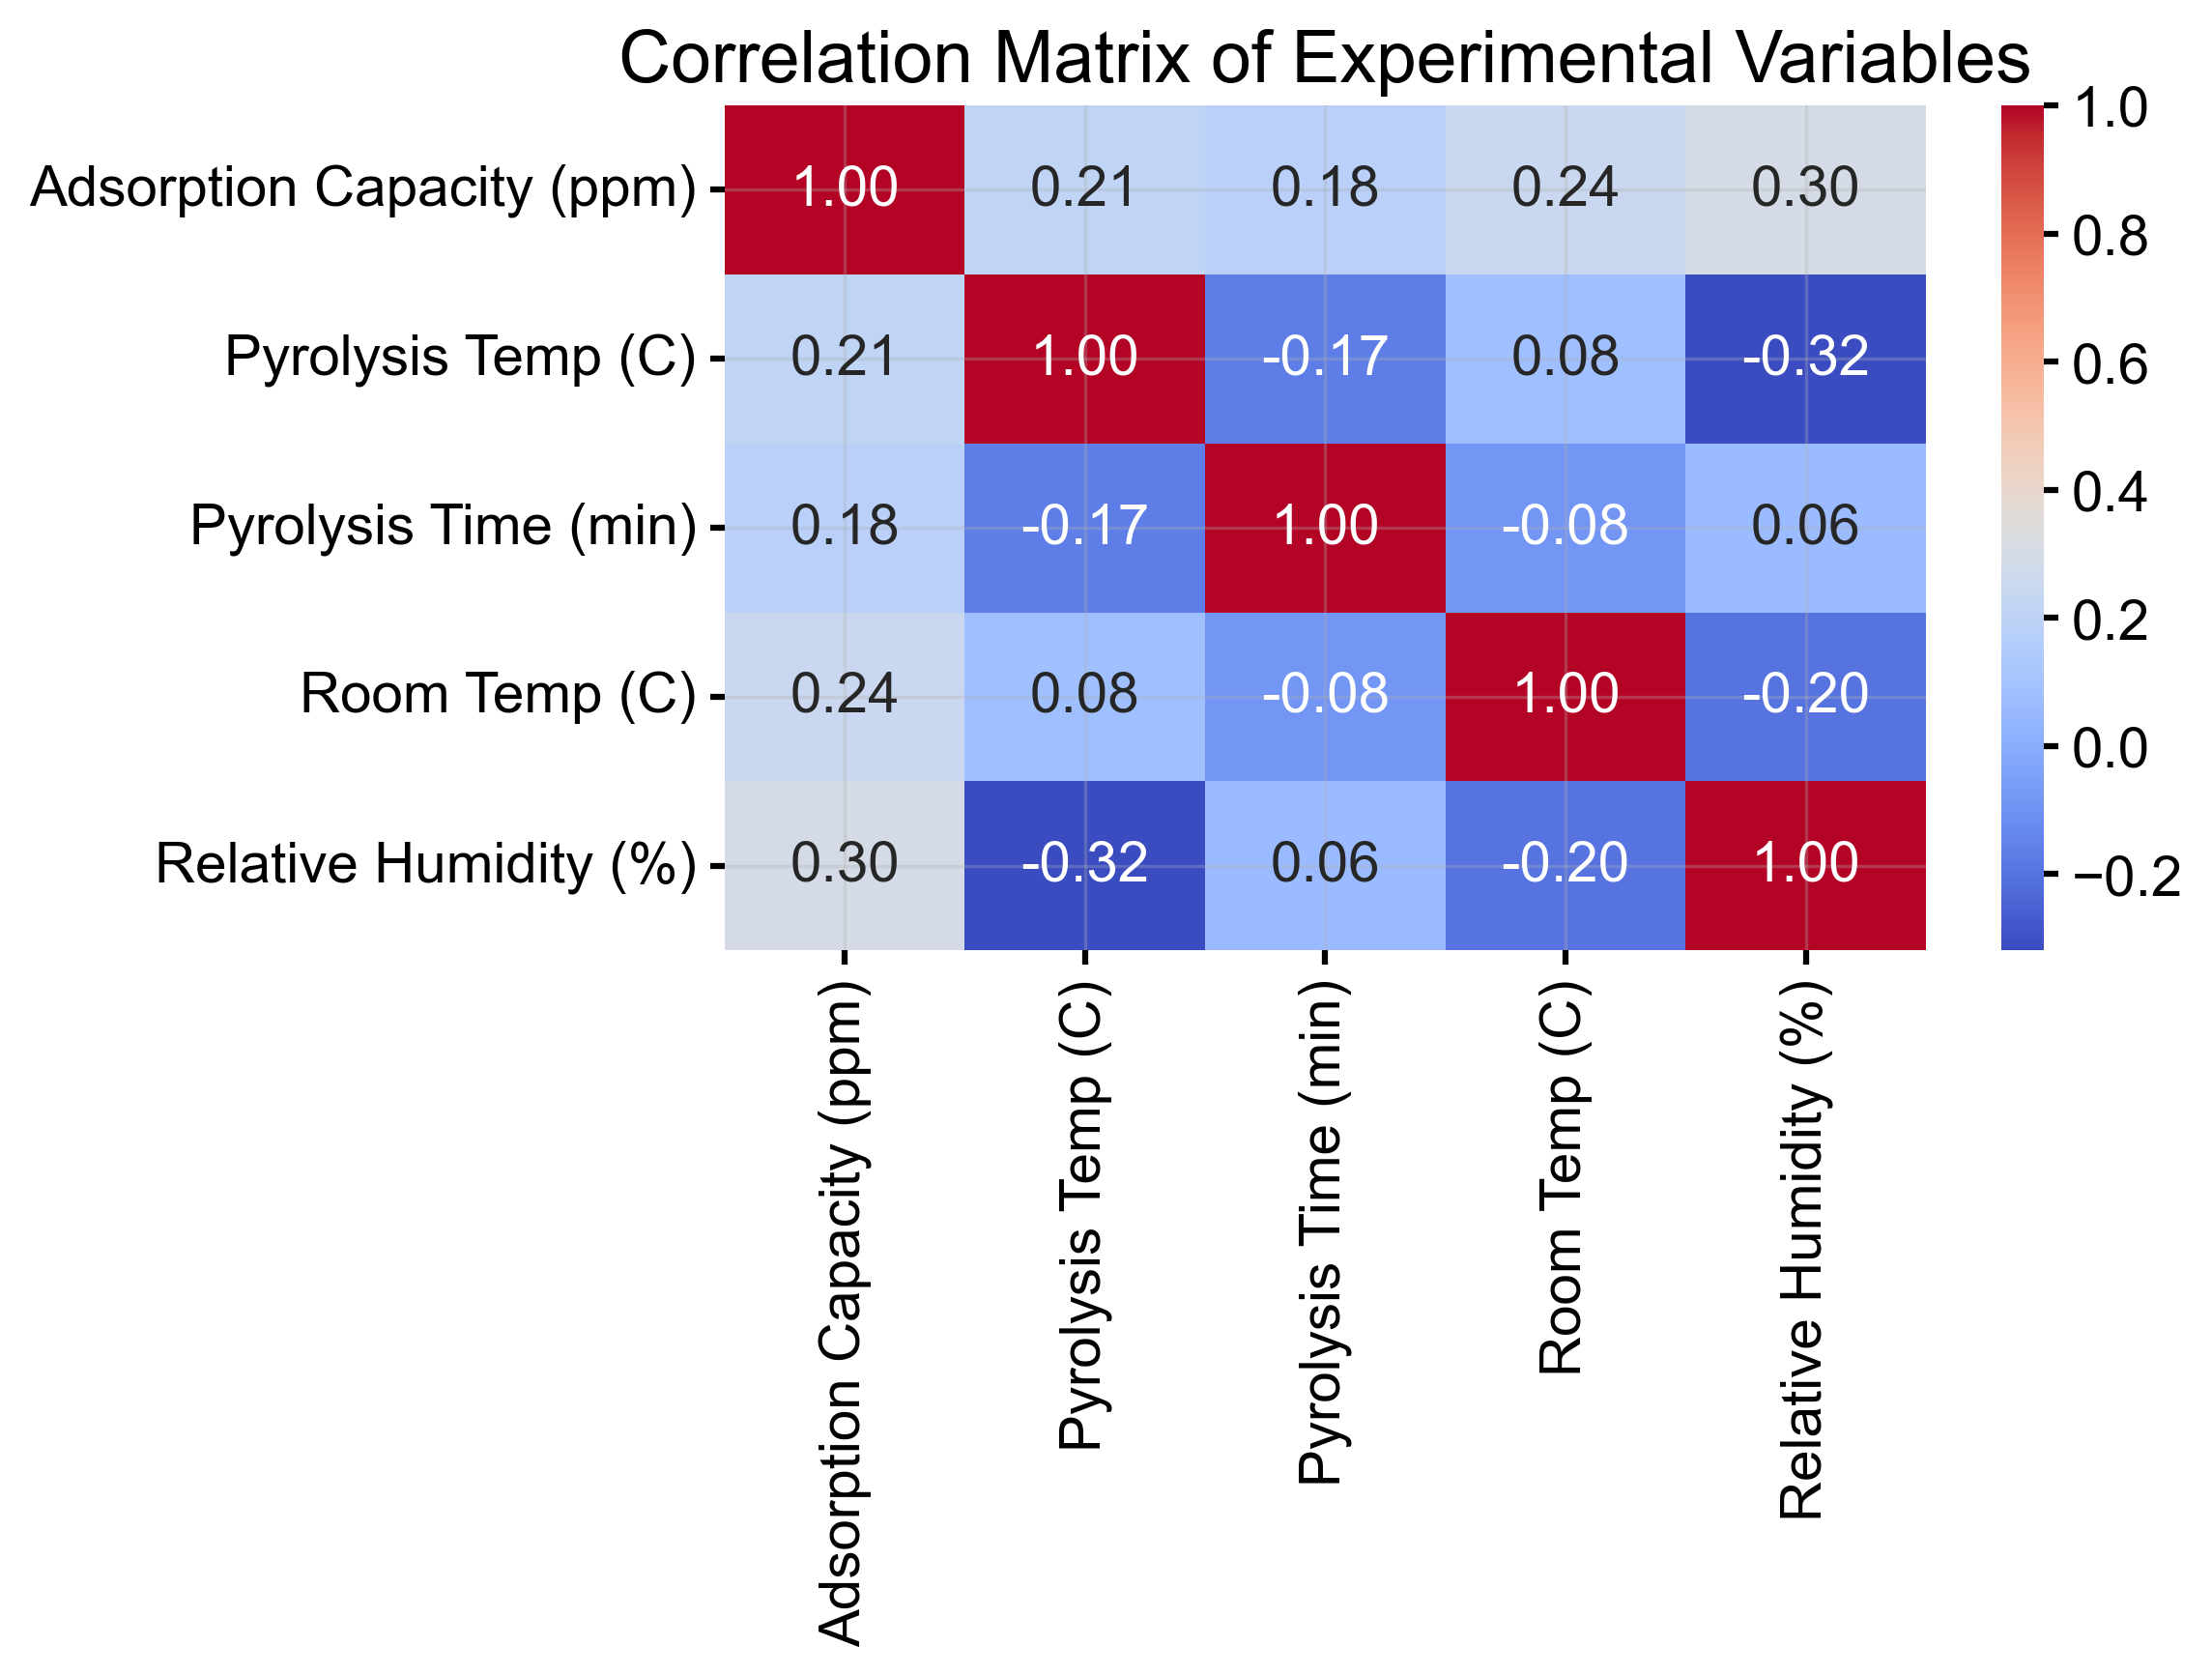

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

###### Correlation Matrix - Both Feedstocks together#############

# Only include numeric columns for correlation
numeric_df = results_df.select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Experimental Variables')
plt.tight_layout()
plt.show()

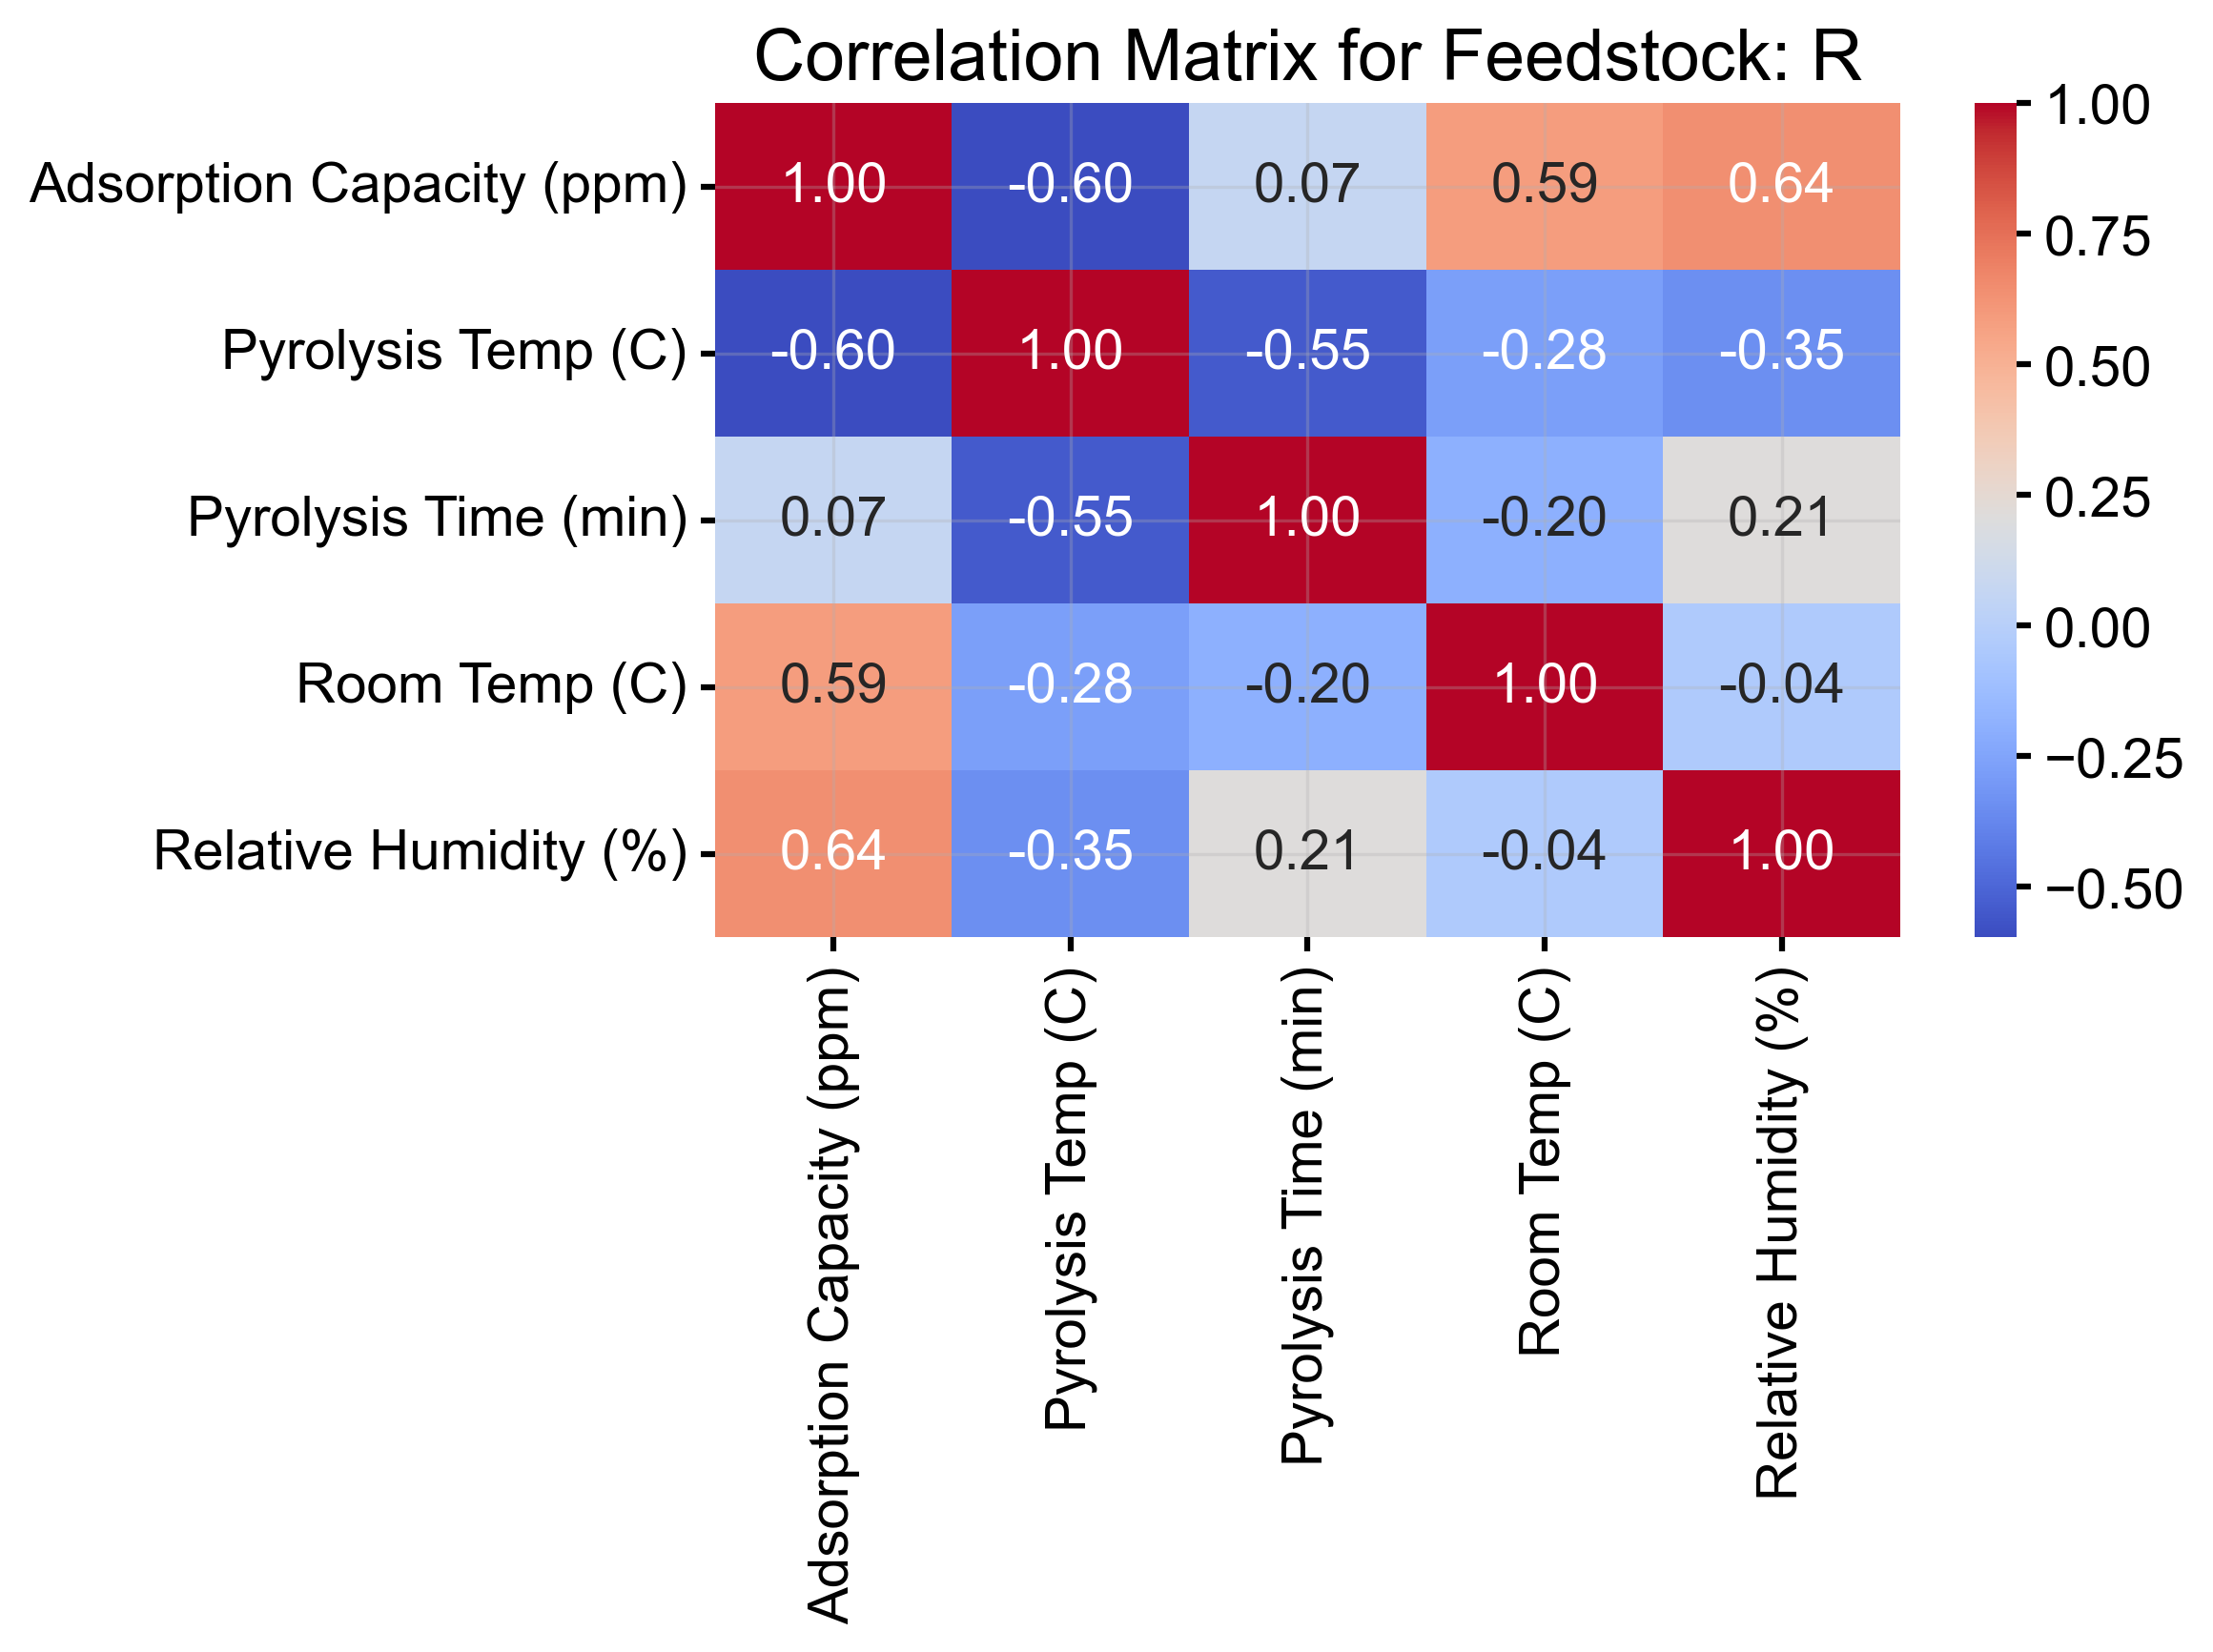

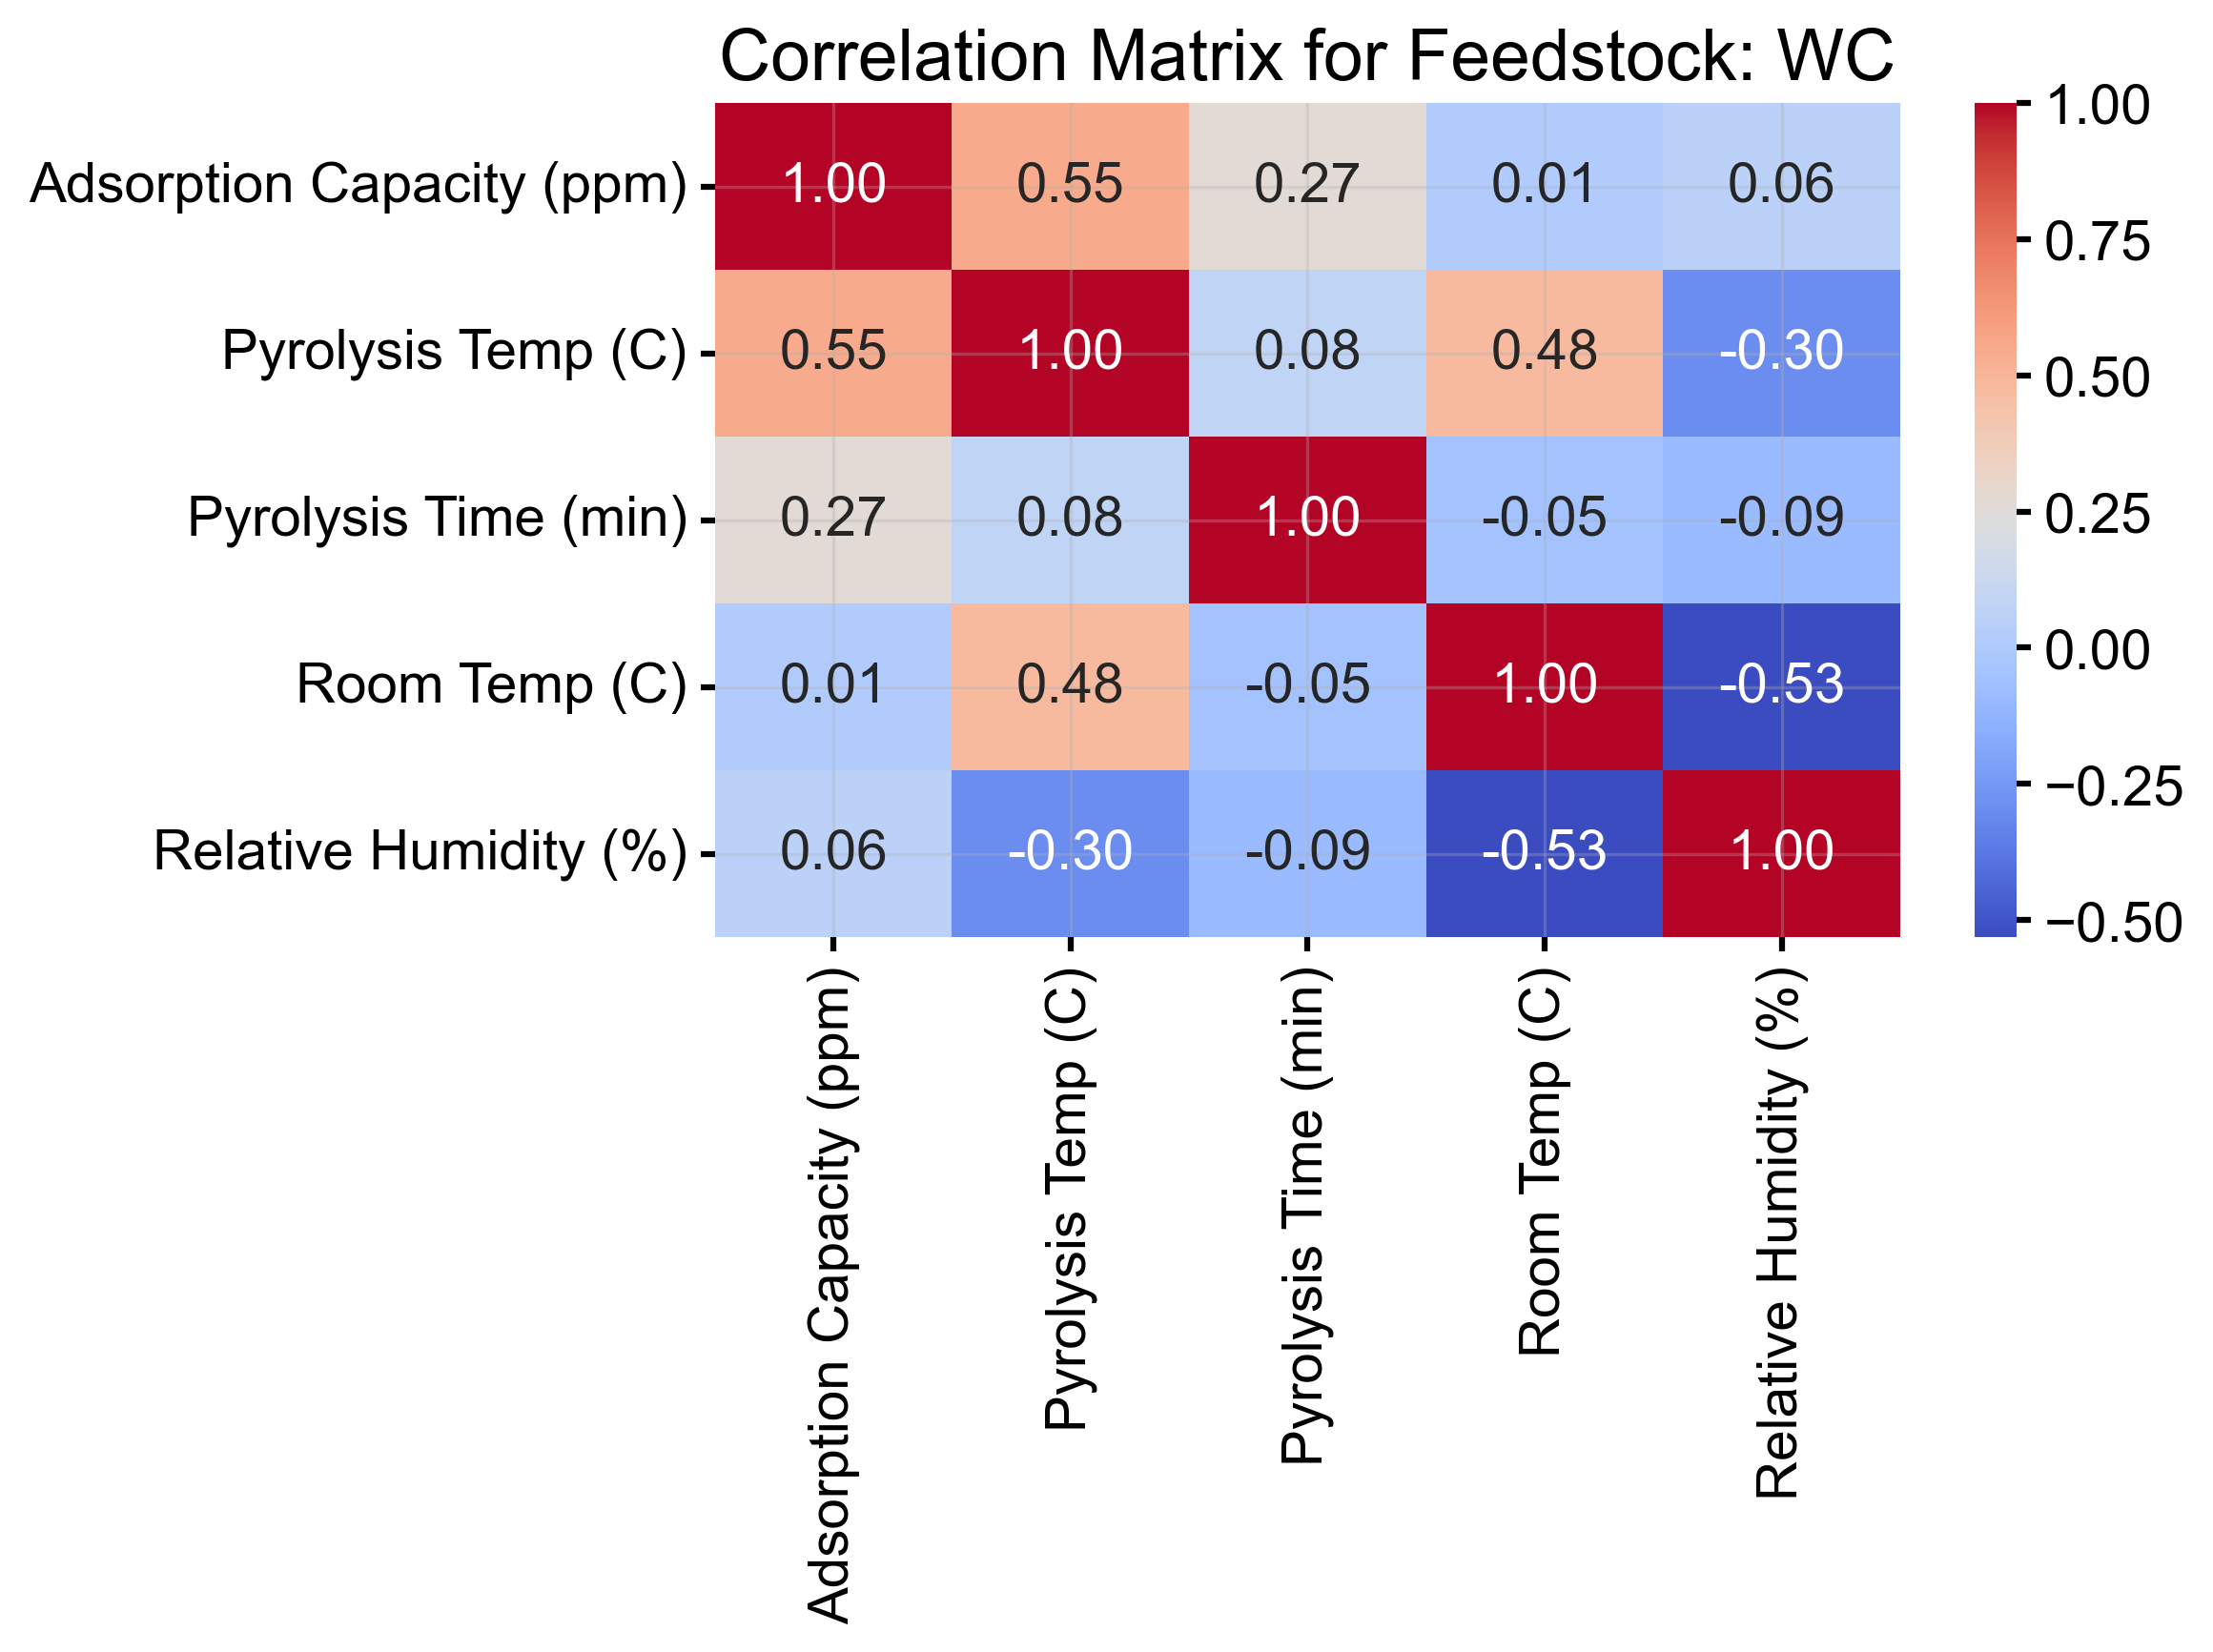

In [63]:
###### Correlation Matrix - Feedstocks separated###########
# Loop through each feedstock type
for feed_type in results_df['Feedstock'].unique():
    # Subset the data for the current feedstock
    subset = results_df[results_df['Feedstock'] == feed_type]
    
    # Only include numeric columns
    numeric_subset = subset.select_dtypes(include=[np.number])
    
    # Compute correlation matrix
    corr_matrix = numeric_subset.corr()

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Matrix for Feedstock: {feed_type}')
    plt.tight_layout()
    plt.show()

In [75]:
import matplotlib.pyplot as plt

# Group data by feedstock type
wc_data = results_df[results_df['Feedstock'] == 'WC']['Adsorption Capacity (ppm)']
r_data = results_df[results_df['Feedstock'] == 'R']['Adsorption Capacity (ppm)']

# Prepare data for boxplot
data   = [wc_data, r_data]
labels = ['WC', 'R']                 # will become the x-tick labels

# Create the boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(
    data,
    labels=labels,                   # <-- the correct kwarg
    patch_artist=True,
    boxprops=dict(facecolor='blue'),
    medianprops=dict(color='black')
)

# Add titles and labels
plt.title('Adsorption Capacity by Feedstock Type')
plt.xlabel('Feedstock Type')
plt.ylabel('Adsorption Capacity (ppm)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

KeyError: 'Adsorption Capacity (ppm)'

In [76]:
import pandas as pd
import numpy as np
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt


# Clean and prepare data
df = df.sort_values(by=['ID', 'run time'])
df['effluent/influent ratio'] = df['effluent mg/m^3'] / df['influent mg/m^3']   #adds a C/C0 column to dataset
df.dropna(subset=['run time', 'influent mg/m^3', 'effluent mg/m^3'], inplace=True) #drops na data

# Store adsorption results
results = []  #blank results table to store our adsorption capacities

# Loop over each unique sample ID
for sample_id, group in df.groupby('ID'):
    group = group.sort_values('run time')
    x = group['run time'].values  # in minutes
    influent = group['influent mg/m^3'].values  # mg/m³
    effluent = group['effluent mg/m^3'].values  # mg/m³
    flow_rate_L_min = group['Flow Rate'].iloc[0]  # L/min
    biochar_mass_g = group['mass(g)'].iloc[0]  # g

    if len(x) < 4:   #removes any dataset that doesn't have enough data
        print(f"Skipping ID {sample_id}: not enough data for polynomial fitting.")
        continue

    # Fit 3rd-degree polynomial to effluent data
    poly_coeffs = np.polyfit(x, effluent, 3) #fits a 3rd order model
    poly_effluent = np.poly1d(poly_coeffs) #calculate the y-values using fitted parameters

    # Create fine time grid for integration
    x_fine = np.linspace(min(x), max(x), 300)
    effluent_fitted = poly_effluent(x_fine)

    # Clip effluent values if they exceed influent
    influent_mean = np.mean(influent)
    effluent_fitted = np.clip(effluent_fitted, 0, influent_mean)

    # Calculate concentration difference (adsorbed) over time
    adsorbed_conc = influent_mean - effluent_fitted  # mg/m³

    # Flow rate in m³/min
    flow_m3_per_min = flow_rate_L_min / 1000

    # Mass removed at each time step = (adsorbed concentration × flow × dt)
    dt = np.gradient(x_fine)  # minutes
    mass_removed_mg = adsorbed_conc * flow_m3_per_min * dt  # mg

    # Total mass adsorbed = area under the curve
    total_mass_adsorbed_mg = np.sum(mass_removed_mg)

    # Adsorption capacity (mg/g)
    adsorption_capacity = total_mass_adsorbed_mg / biochar_mass_g

    results.append({
        'ID': sample_id,
        'adsorption_capacity_mg_per_g': adsorption_capacity
    })

    # Optional: plot for visual inspection
    plt.plot(x_fine, effluent_fitted / influent_mean, label=f'ID {sample_id}')

plt.xlabel('Run Time (min)')
plt.ylabel('Normalized Effluent Concentration (C/C₀)')
plt.title('Effluent Profile with Polynomial Fit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Output summary
results_df = pd.DataFrame(results)
print(results_df)

KeyError: 'ID'

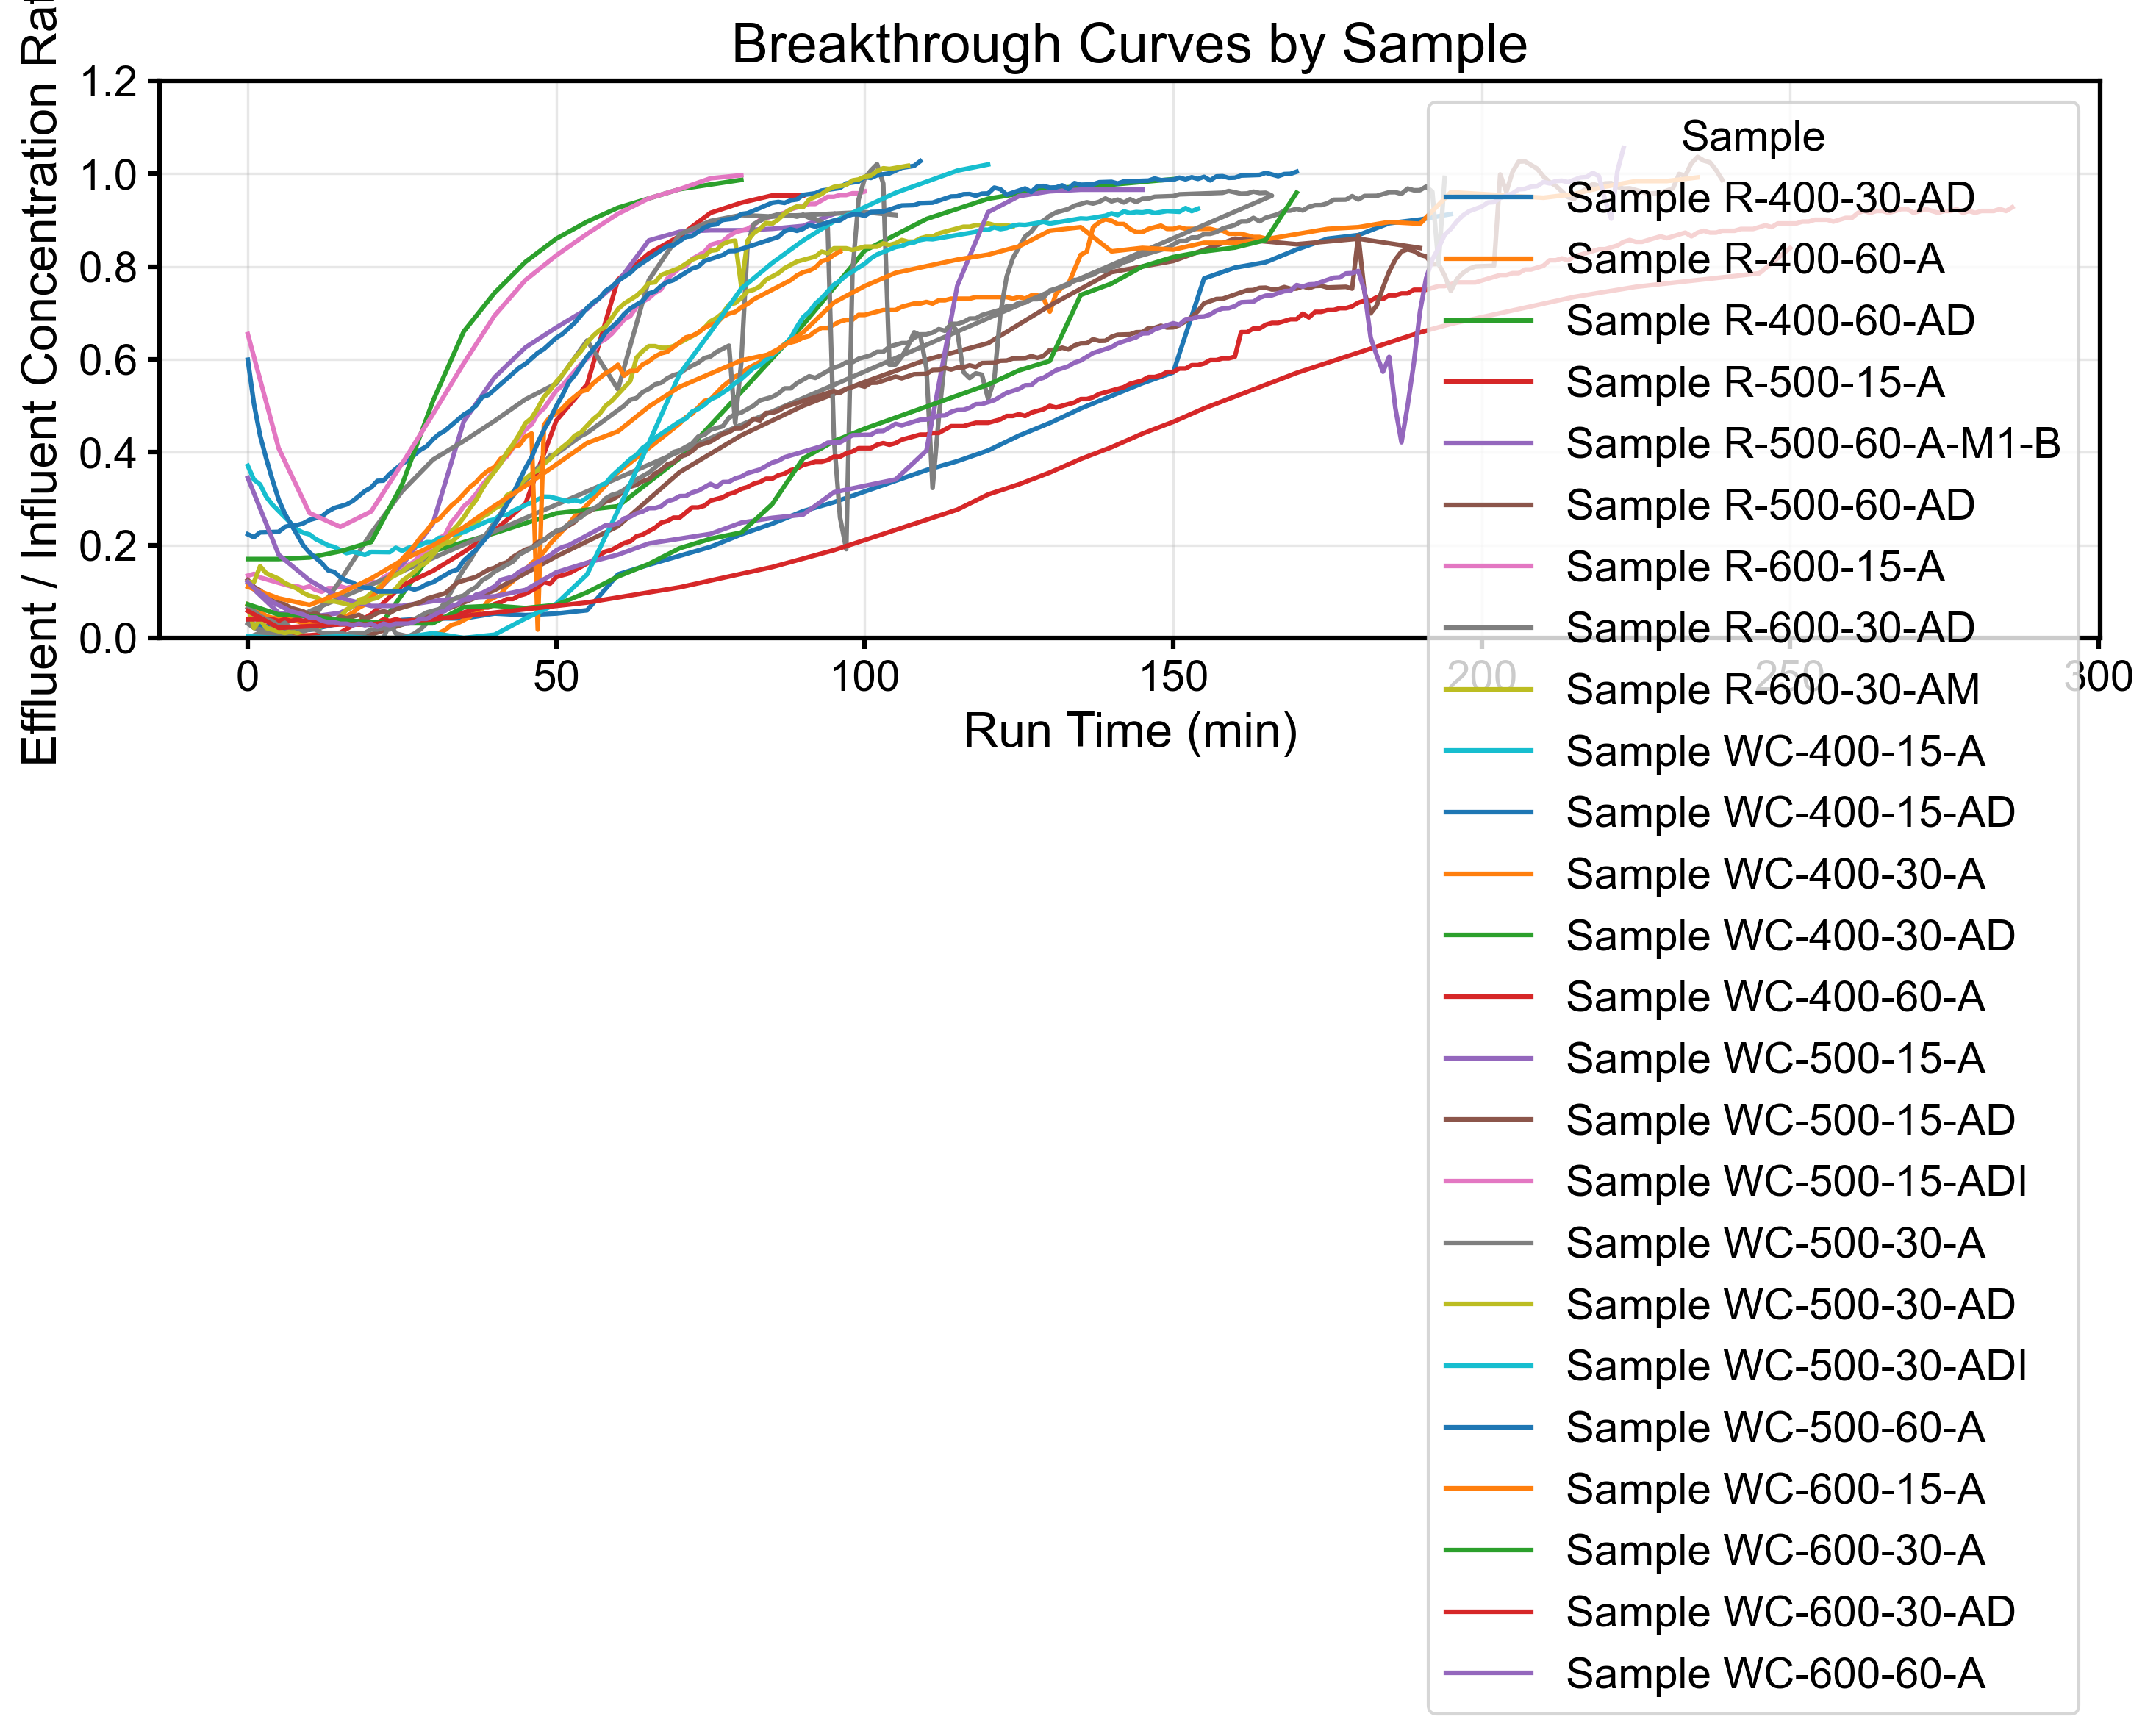

In [65]:
# 1. Read the file
df = pd.read_excel('ammoniatest4.xlsx')
df.columns = df.columns.str.strip()     # tidy up header whitespace

# 2. Use “Sample” as the identifier
df = df.rename(columns={'Sample': 'id'})

# 3. Calculate the effluent / influent ratio
df['effluent/influent ratio'] = (
    df['effluent mg/m^3'] / df['influent mg/m^3']
)

# 4. Plot breakthrough curves, one line per sample
plt.figure(figsize=(10, 6))
for sample_id, group in df.groupby('id'):
    plt.plot(group['run time'],              # x-axis
             group['effluent/influent ratio'],
             label=f'Sample {sample_id}')

plt.xlabel('Run Time (min)')
plt.ylabel('Effluent / Influent Concentration Ratio')
plt.title('Breakthrough Curves by Sample')
plt.ylim(0, 1.2)
plt.legend(title="Sample")
plt.grid(True)
plt.tight_layout()
plt.show()

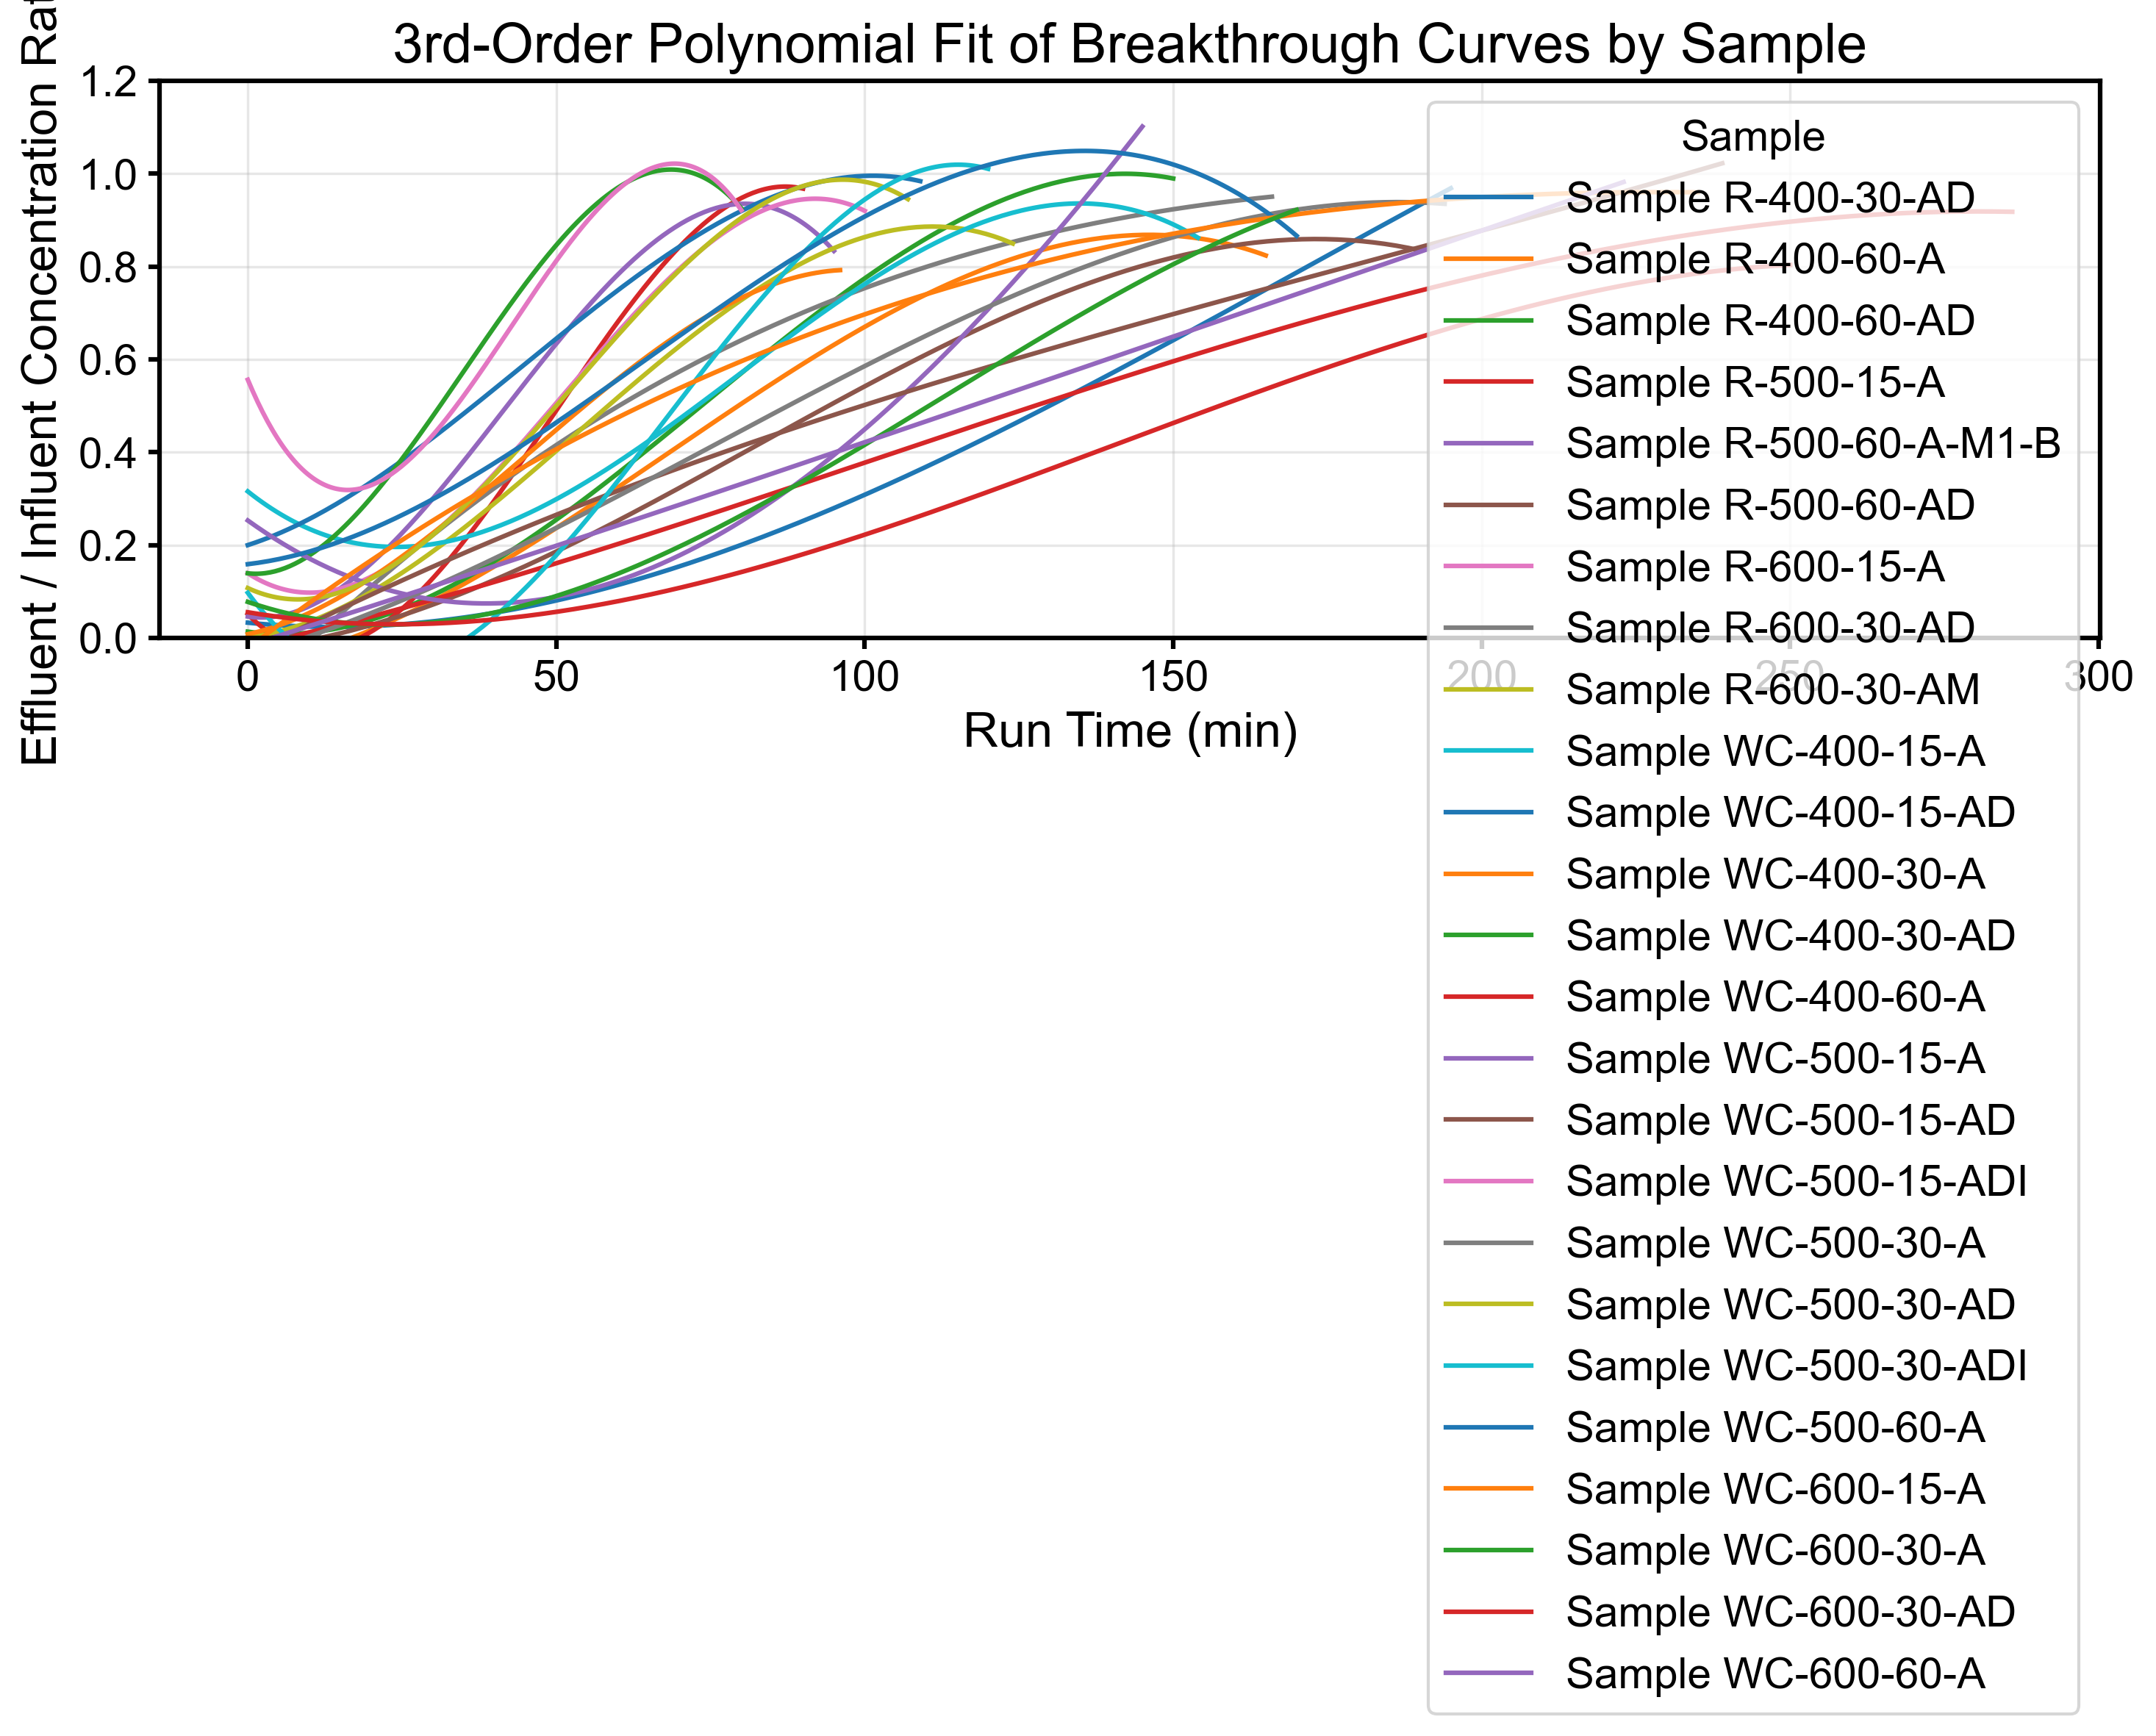

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- 1. Load & clean ----------
df = pd.read_excel('ammoniatest4.xlsx')
df.columns = df.columns.str.strip()          # trim spaces

# Use “Sample” as our ID
df = df.rename(columns={'Sample': 'id'})

# ---------- 2. Derived columns ----------
df['effluent/influent ratio'] = (
    df['effluent mg/m^3'] / df['influent mg/m^3']
)

# ---------- 3. Plot w/ cubic fit ----------
plt.figure(figsize=(10, 6))

for sample_id, group in df.groupby('id'):
    x = group['run time'].values
    y = group['effluent/influent ratio'].values

    # keep only finite pairs
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]

    if len(x) >= 4:                       # ≥4 points → 3rd-order fit possible
        coeffs = np.polyfit(x, y, 3)
        poly   = np.poly1d(coeffs)

        x_fit = np.linspace(x.min(), x.max(), 200)
        y_fit = poly(x_fit)

        plt.plot(x_fit, y_fit, label=f'Sample {sample_id}')
    else:
        print(f"Skipping Sample {sample_id}: not enough points (need ≥4).")

plt.xlabel('Run Time (min)')
plt.ylabel('Effluent / Influent Concentration Ratio')
plt.title('3rd-Order Polynomial Fit of Breakthrough Curves by Sample')
plt.ylim(0, 1.2)
plt.legend(title='Sample')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\j0983\AppData\Local\Temp\ipykernel_26112\3381413292.py:59: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  plt.tight_layout()
C:\Users\j0983\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


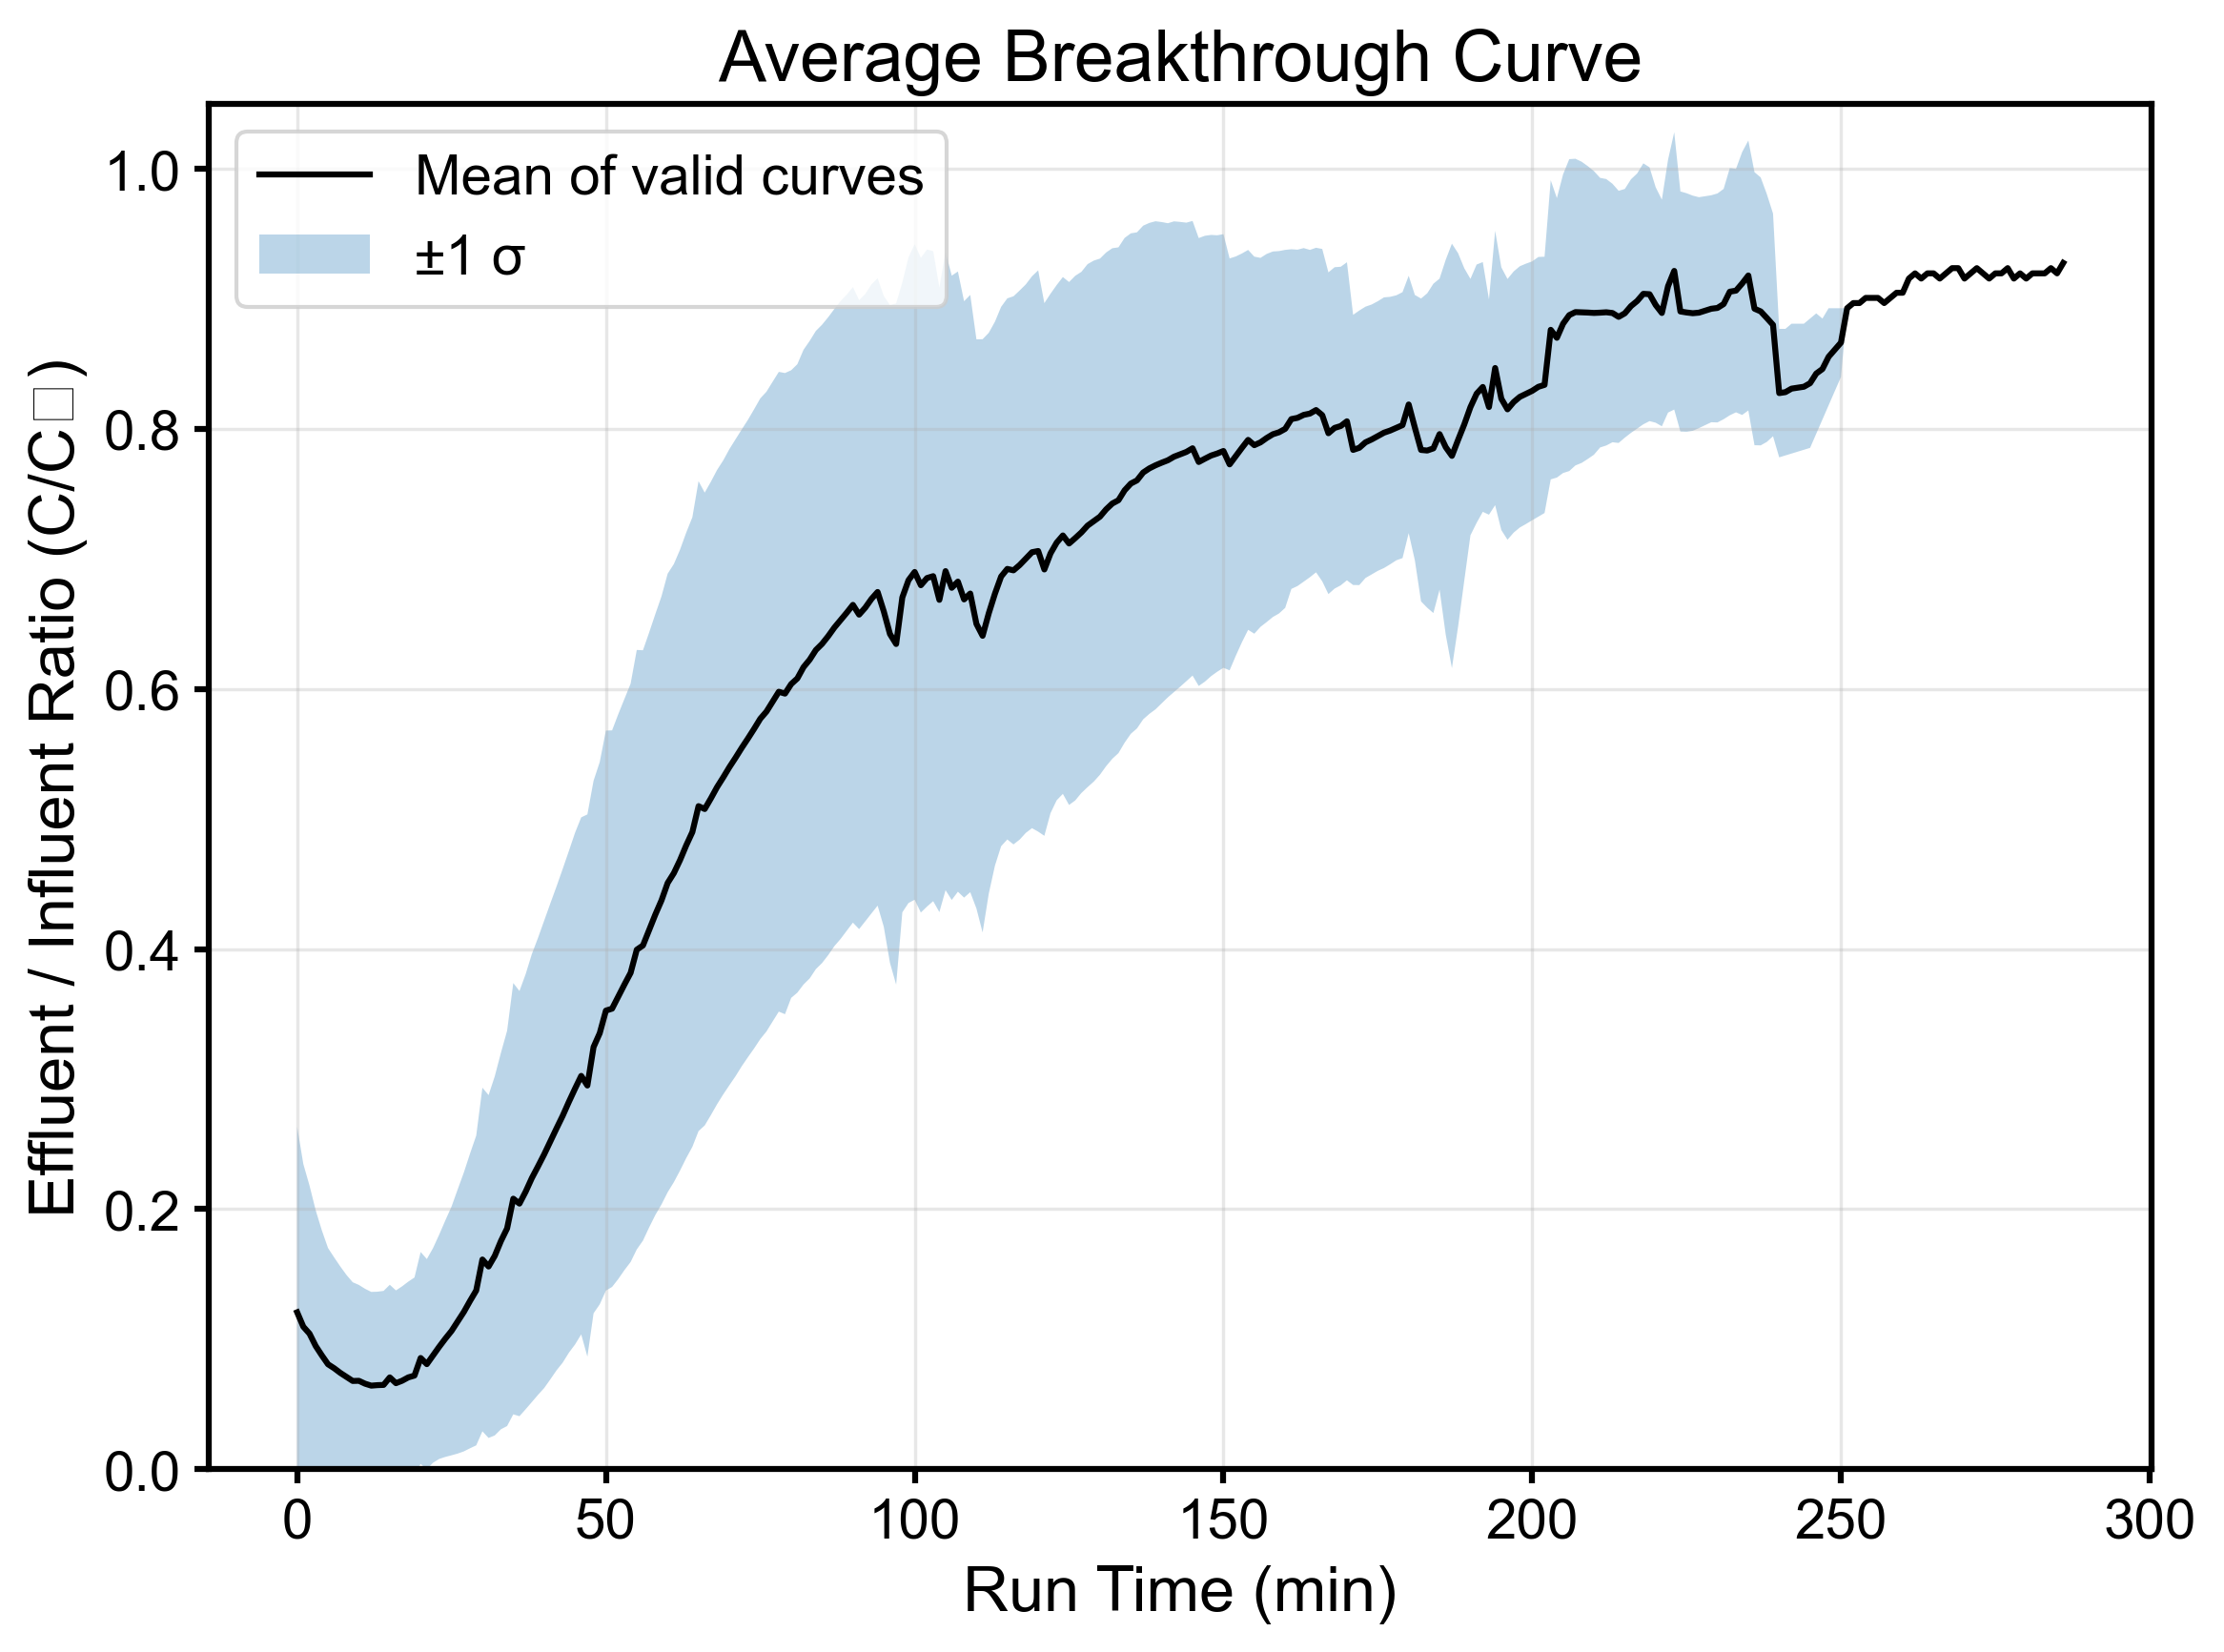

C:\Users\j0983\AppData\Local\Temp\ipykernel_26112\3381413292.py:79: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  plt.tight_layout()


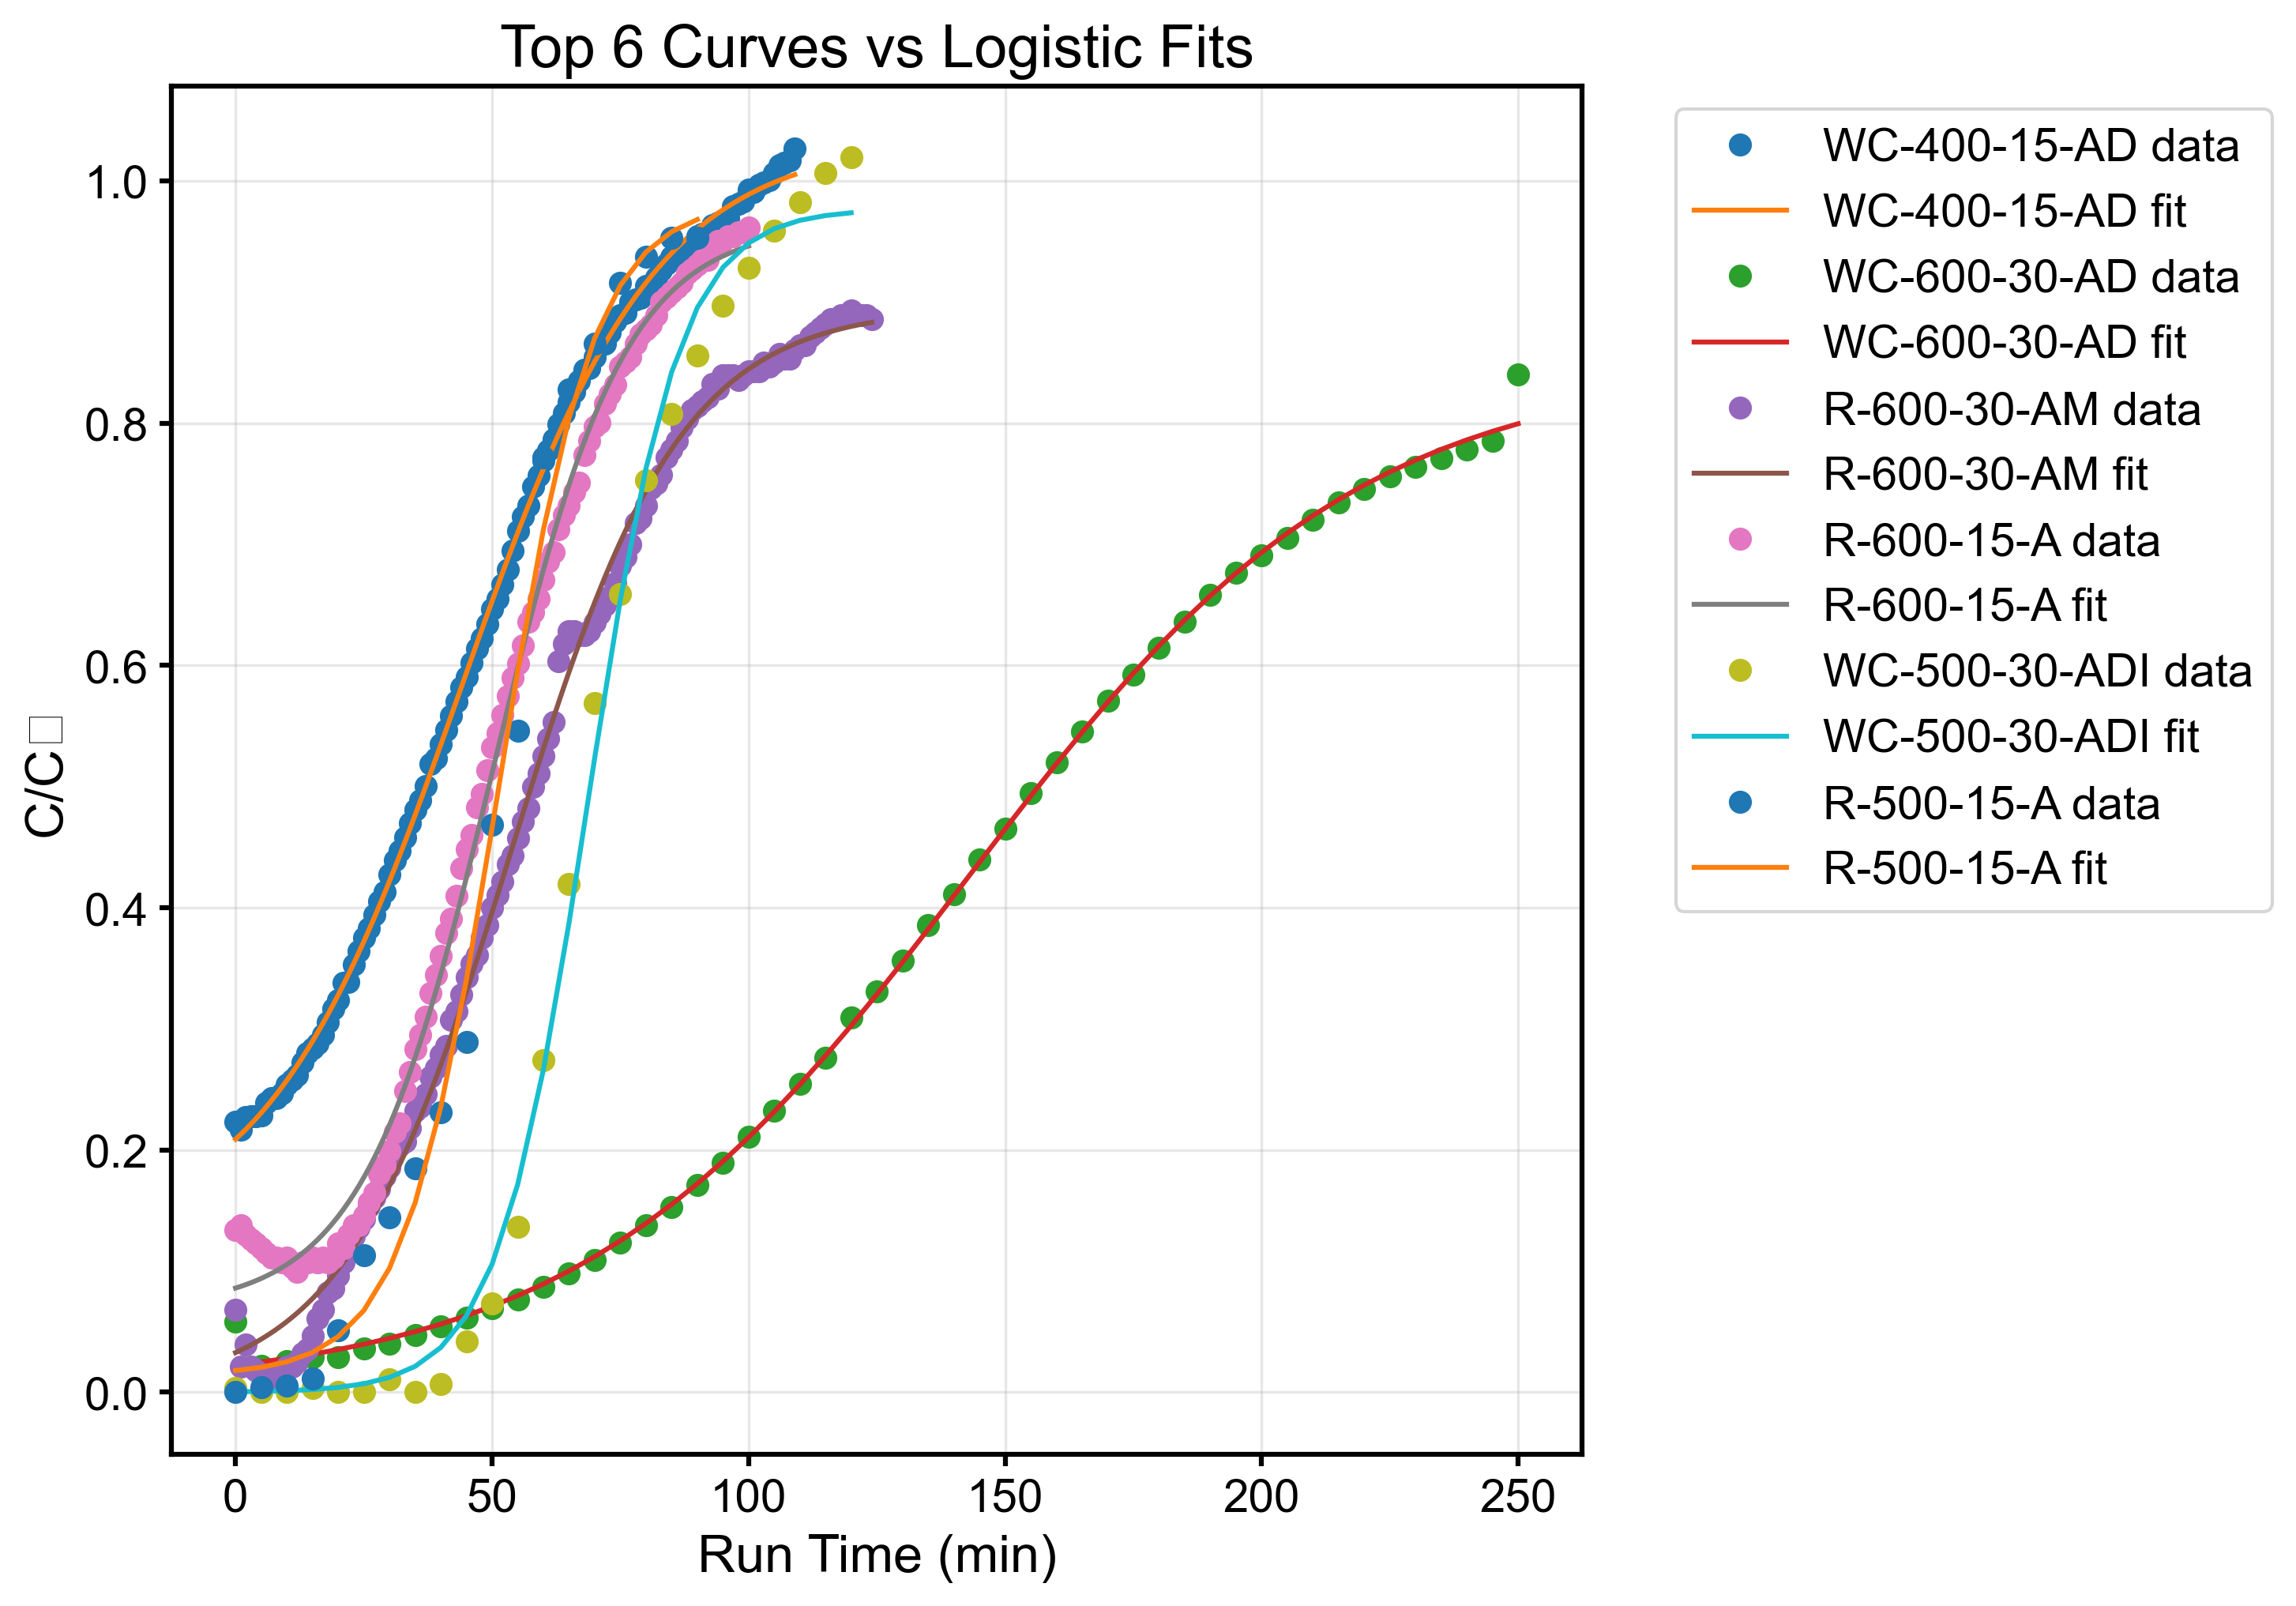

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ---------- 1 | Load the data ----------
df = pd.read_excel("ammoniatest4.xlsx", engine="openpyxl")
df["ratio"] = df["effluent mg/m^3"] / df["influent mg/m^3"]
df_valid = df[df["Valid: (Y/N)"] == "Y"]

# ---------- 2 | Average curve on a common grid ----------
t_grid = np.arange(0, df_valid["run time"].max() + 1, 1)

def interp_curve(group):
    t, y = group["run time"].values, group["ratio"].values
    idx = np.argsort(t)
    return np.interp(t_grid, t[idx], y[idx], left=np.nan, right=np.nan)

ratio_matrix = np.vstack(df_valid.groupby("Sample").apply(interp_curve).values)
mean_ratio   = np.nanmean(ratio_matrix, axis=0)
std_ratio    = np.nanstd(ratio_matrix, axis=0)

# ---------- 3 | Fit 4-parameter logistic to each curve ----------
def logistic4(t, A, B, k, t0):
    return A + (B - A) / (1 + np.exp(-k * (t - t0)))
#A       | lower asymptote (ratio at $t\to-\infty$; here ≈ initial baseline)
#B       | upper asymptote (plateau value; ideally → 1)                      
#k       | steepness (slope at the inflection point)                         
#t_{0}   | “midpoint time” when the ratio is halfway between $A$ and $B$     


fit_rows = []
for sid, g in df_valid.groupby("Sample"):
    t, y = g["run time"].values, g["ratio"].values
    p0   = [max(0, y.min()), min(1.05, y.max()), 0.05, np.median(t)]
    bounds = ([0, 0.5, 0, 0], [0.5, 1.2, 1, t.max() * 1.5])
    try:
        popt, _ = curve_fit(logistic4, t, y, p0=p0, bounds=bounds, maxfev=20000)
        A, B, k, t0 = popt
        r2 = 1 - np.sum((y - logistic4(t, *popt))**2) / np.sum((y - y.mean())**2)
    except RuntimeError:
        A = B = k = t0 = r2 = np.nan
    fit_rows.append(dict(ID=sid, A=A, B=B, k=k, t0=t0, R2=r2))

fits = pd.DataFrame(fit_rows).sort_values("R2", ascending=False)
fits.to_excel("logistic4_fits.xlsx", index=False)   # handy for later

# ---------- 4 | Visuals ----------
# 4a. Average curve
plt.figure(figsize=(8, 6))
plt.plot(t_grid, mean_ratio, color="black", label="Mean of valid curves")
plt.fill_between(t_grid, mean_ratio - std_ratio, mean_ratio + std_ratio,
                 alpha=0.3, label="±1 σ")
plt.ylim(0, 1.05)
plt.xlabel("Run Time (min)")
plt.ylabel("Effluent / Influent Ratio (C/C₀)")
plt.title("Average Breakthrough Curve")
plt.legend()
plt.tight_layout()
plt.show()

# 4b. Top N logistic fits (change N as you like)
N = 6
for sid in fits.head(N)["ID"]:
    g = df_valid[df_valid["Sample"] == sid]
    t, y = g["run time"].values, g["ratio"].values

    # get the four logistic parameters for this sample
    row = fits.loc[fits["ID"] == sid].iloc[0]
    A, B, k, t0 = row["A"], row["B"], row["k"], row["t0"]

    plt.plot(t, y, "o", label=f"{sid} data")
    plt.plot(t, logistic4(t, A, B, k, t0), "-", label=f"{sid} fit")

plt.xlabel("Run Time (min)")
plt.ylabel("C/C₀")
plt.title(f"Top {N} Curves vs Logistic Fits")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

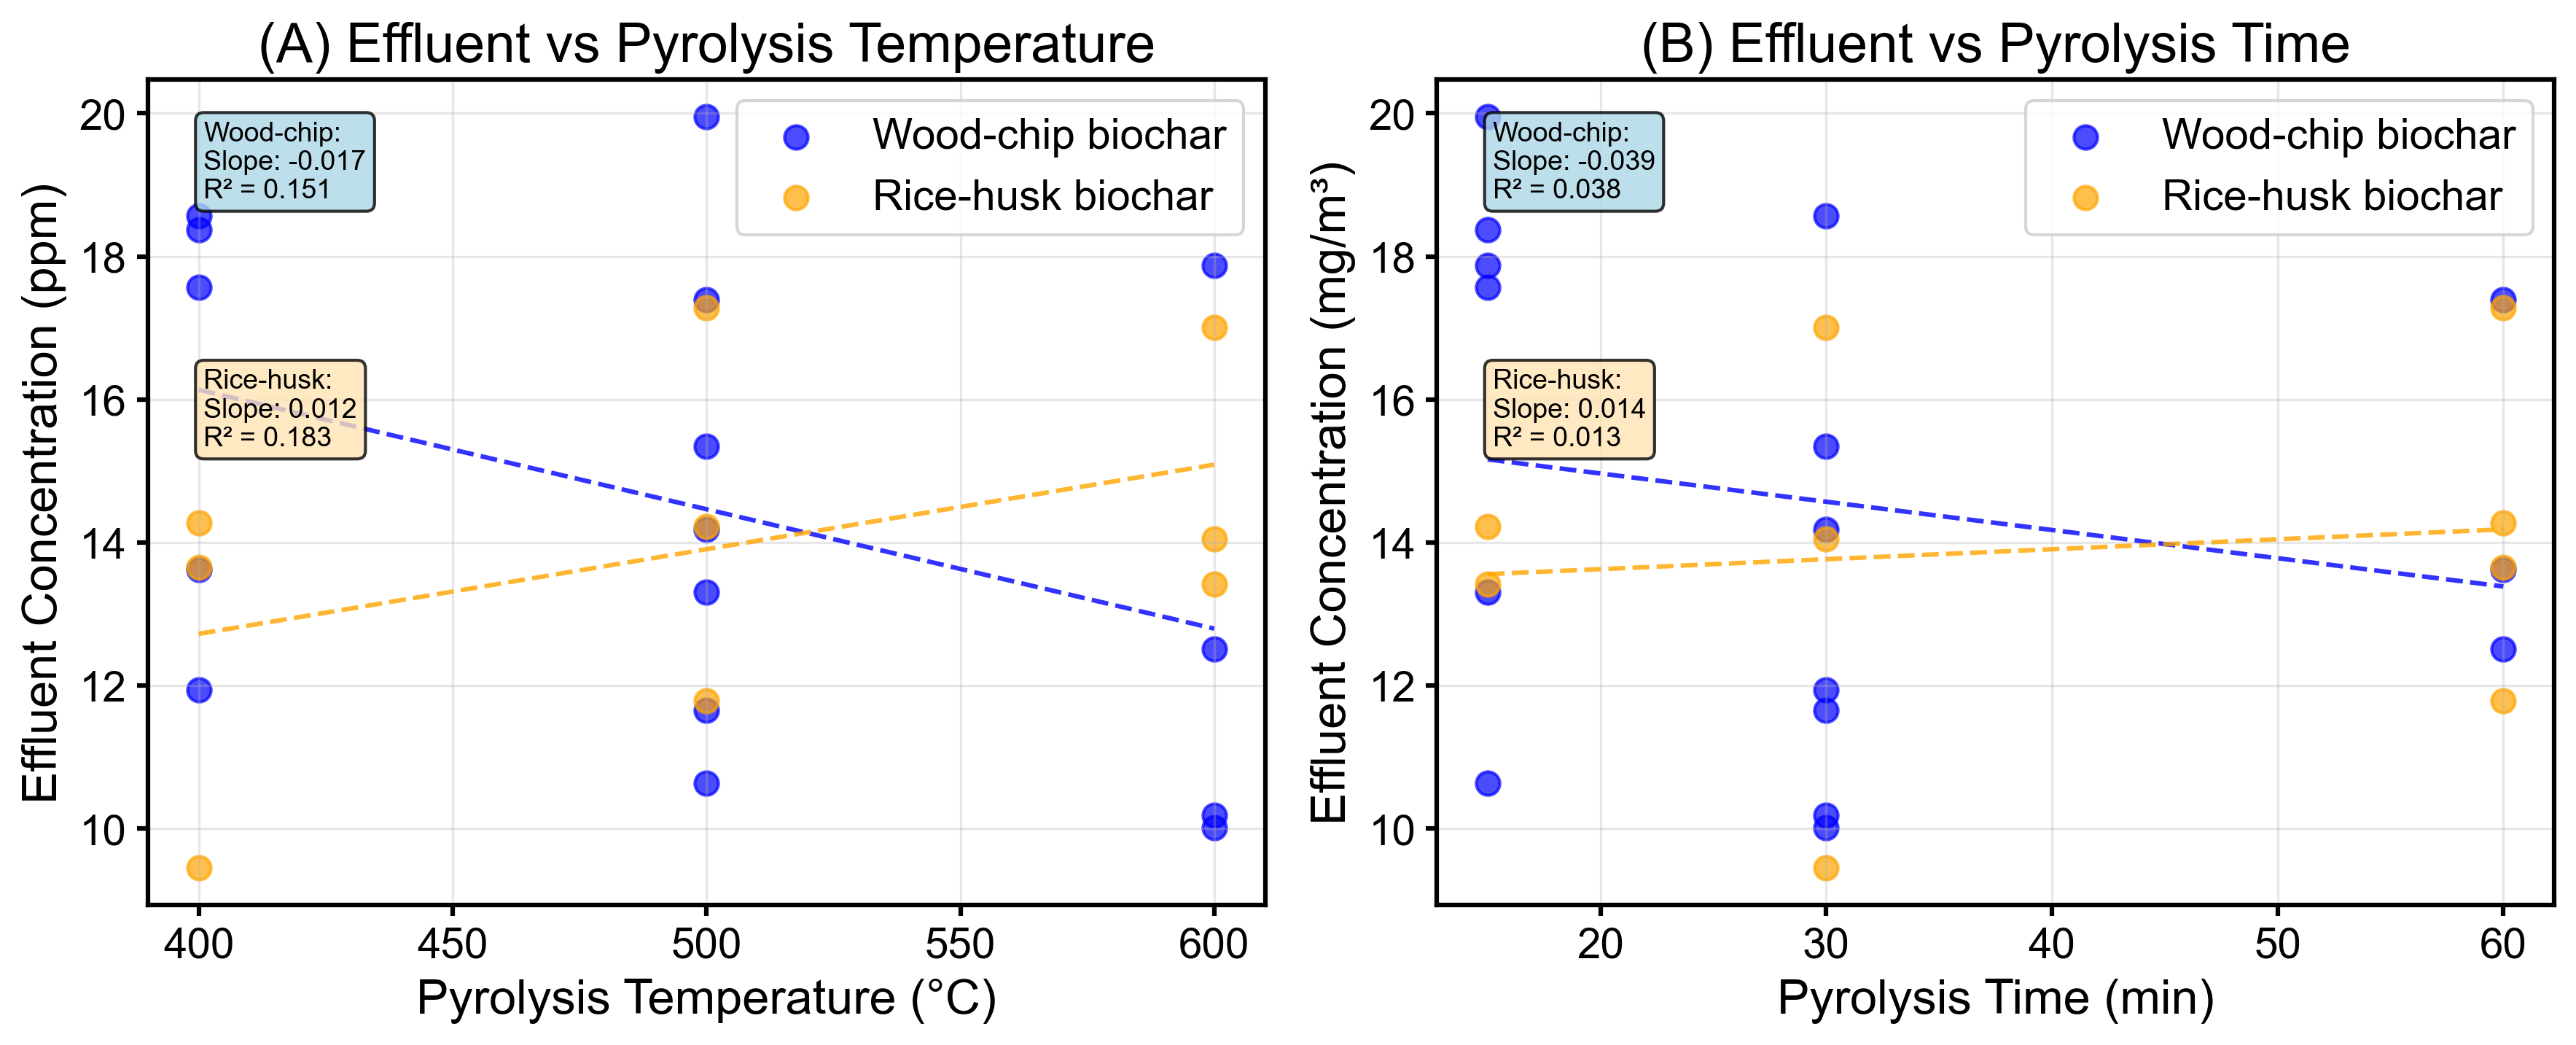

=== FIGURE 3.4 STATISTICAL SUMMARY ===
Data points: 25 samples
Wood-chip samples: 16
Rice-husk samples: 9

WOOD-CHIP BIOCHAR:
  Temperature relationship: slope = -0.0167, R² = 0.151, p = 0.1376
  Time relationship: slope = -0.0395, R² = 0.038, p = 0.4687
RICE-HUSK BIOCHAR:
  Temperature relationship: slope = 0.0118, R² = 0.183, p = 0.2509
  Time relationship: slope = 0.0139, R² = 0.013, p = 0.7678

=== PROCESSED DATA ===
         Sample  Avg_Effluent_Conc  Pyrolysis_Temp  Pyrolysis_Time Feedstock
    R-400-30-AD           9.457500             400              30         R
     R-400-60-A          13.649398             400              60         R
    R-400-60-AD          14.275000             400              60         R
     R-500-15-A          14.223684             500              15         R
R-500-60-A-M1-B          17.285000             500              60         R
    R-500-60-AD          11.790000             500              60         R
     R-600-15-A          13.414851  

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load the data (assuming your CSV file contains the raw time series data)
df = pd.read_excel('ammoniatest4.xlsx')
df = df.sort_values(by=['Sample', 'run time'])

# Calculate average effluent concentration for each sample
# (This represents the breakthrough performance)
results = []
for sample_id, group in df.groupby('Sample'):
    # Calculate average effluent concentration during the experimental run
    avg_effluent = group['effluent ppm'].mean()
    
    # Extract experimental parameters
    temp = group['Biochar Temp'].iloc[0]  # Pyrolysis temp (C)
    ptime = group['Pyrolysis Time'].iloc[0]         # Pyrolysis time (min)
    feed = group['Feed'].iloc[0]          # Feedstock (WC/R)
    
    results.append({
        'Sample': sample_id,
        'Avg_Effluent_Conc': avg_effluent,
        'Pyrolysis_Temp': temp,
        'Pyrolysis_Time': ptime,
        'Feedstock': feed
    })

results_df = pd.DataFrame(results)

# Create Figure 3.4 with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Panel A: Effluent concentration vs Pyrolysis Temperature
# Separate data by feedstock
wc_data = results_df[results_df['Feedstock'] == 'WC']
r_data = results_df[results_df['Feedstock'] == 'R']

# Plot Panel A
ax1.scatter(wc_data['Pyrolysis_Temp'], wc_data['Avg_Effluent_Conc'], 
           c='blue', label='Wood-chip biochar', s=60, alpha=0.7)
ax1.scatter(r_data['Pyrolysis_Temp'], r_data['Avg_Effluent_Conc'], 
           c='orange', label='Rice-husk biochar', s=60, alpha=0.7)

# Linear regression for Panel A
if len(wc_data) > 1:
    slope_wc_temp, intercept_wc_temp, r_wc_temp, p_wc_temp, _ = linregress(
        wc_data['Pyrolysis_Temp'], wc_data['Avg_Effluent_Conc'])
    temp_range_wc = np.linspace(wc_data['Pyrolysis_Temp'].min(), 
                                wc_data['Pyrolysis_Temp'].max(), 100)
    ax1.plot(temp_range_wc, slope_wc_temp * temp_range_wc + intercept_wc_temp, 
             '--', color='blue', alpha=0.8)
    
    # Add inset box for WC
    textstr_wc = f'Wood-chip:\nSlope: {slope_wc_temp:.3f}\nR² = {r_wc_temp**2:.3f}'
    ax1.text(0.05, 0.95, textstr_wc, transform=ax1.transAxes, fontsize=9,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

if len(r_data) > 1:
    slope_r_temp, intercept_r_temp, r_r_temp, p_r_temp, _ = linregress(
        r_data['Pyrolysis_Temp'], r_data['Avg_Effluent_Conc'])
    temp_range_r = np.linspace(r_data['Pyrolysis_Temp'].min(), 
                               r_data['Pyrolysis_Temp'].max(), 100)
    ax1.plot(temp_range_r, slope_r_temp * temp_range_r + intercept_r_temp, 
             '--', color='orange', alpha=0.8)
    
    # Add inset box for R
    textstr_r = f'Rice-husk:\nSlope: {slope_r_temp:.3f}\nR² = {r_r_temp**2:.3f}'
    ax1.text(0.05, 0.65, textstr_r, transform=ax1.transAxes, fontsize=9,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='moccasin', alpha=0.8))

ax1.set_xlabel('Pyrolysis Temperature (°C)')
ax1.set_ylabel('Effluent Concentration (ppm)')
ax1.set_title('(A) Effluent vs Pyrolysis Temperature')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Panel B: Effluent concentration vs Pyrolysis Time
ax2.scatter(wc_data['Pyrolysis_Time'], wc_data['Avg_Effluent_Conc'], 
           c='blue', label='Wood-chip biochar', s=60, alpha=0.7)
ax2.scatter(r_data['Pyrolysis_Time'], r_data['Avg_Effluent_Conc'], 
           c='orange', label='Rice-husk biochar', s=60, alpha=0.7)

# Linear regression for Panel B
if len(wc_data) > 1:
    slope_wc_time, intercept_wc_time, r_wc_time, p_wc_time, _ = linregress(
        wc_data['Pyrolysis_Time'], wc_data['Avg_Effluent_Conc'])
    time_range_wc = np.linspace(wc_data['Pyrolysis_Time'].min(), 
                                wc_data['Pyrolysis_Time'].max(), 100)
    ax2.plot(time_range_wc, slope_wc_time * time_range_wc + intercept_wc_time, 
             '--', color='blue', alpha=0.8)
    
    # Add inset box for WC
    textstr_wc_time = f'Wood-chip:\nSlope: {slope_wc_time:.3f}\nR² = {r_wc_time**2:.3f}'
    ax2.text(0.05, 0.95, textstr_wc_time, transform=ax2.transAxes, fontsize=9,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

if len(r_data) > 1:
    slope_r_time, intercept_r_time, r_r_time, p_r_time, _ = linregress(
        r_data['Pyrolysis_Time'], r_data['Avg_Effluent_Conc'])
    time_range_r = np.linspace(r_data['Pyrolysis_Time'].min(), 
                               r_data['Pyrolysis_Time'].max(), 100)
    ax2.plot(time_range_r, slope_r_time * time_range_r + intercept_r_time, 
             '--', color='orange', alpha=0.8)
    
    # Add inset box for R
    textstr_r_time = f'Rice-husk:\nSlope: {slope_r_time:.3f}\nR² = {r_r_time**2:.3f}'
    ax2.text(0.05, 0.65, textstr_r_time, transform=ax2.transAxes, fontsize=9,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='moccasin', alpha=0.8))

ax2.set_xlabel('Pyrolysis Time (min)')
ax2.set_ylabel('Effluent Concentration (mg/m³)')
ax2.set_title('(B) Effluent vs Pyrolysis Time')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistical summary
print("=== FIGURE 3.4 STATISTICAL SUMMARY ===")
print(f"Data points: {len(results_df)} samples")
print(f"Wood-chip samples: {len(wc_data)}")
print(f"Rice-husk samples: {len(r_data)}")
print()

if len(wc_data) > 1:
    print("WOOD-CHIP BIOCHAR:")
    print(f"  Temperature relationship: slope = {slope_wc_temp:.4f}, R² = {r_wc_temp**2:.3f}, p = {p_wc_temp:.4f}")
    print(f"  Time relationship: slope = {slope_wc_time:.4f}, R² = {r_wc_time**2:.3f}, p = {p_wc_time:.4f}")

if len(r_data) > 1:
    print("RICE-HUSK BIOCHAR:")
    print(f"  Temperature relationship: slope = {slope_r_temp:.4f}, R² = {r_r_temp**2:.3f}, p = {p_r_temp:.4f}")
    print(f"  Time relationship: slope = {slope_r_time:.4f}, R² = {r_r_time**2:.3f}, p = {p_r_time:.4f}")

# Display the processed data
print("\n=== PROCESSED DATA ===")
print(results_df.to_string(index=False))

In [69]:
# --- User parameters --------------------------------------------------
DATA_FILE = 'ammoniatest4.xlsx'        # Excel file path (in same folder)
SHEET_NAME = None                      # Set to sheet name or None for first
BEGINNING_RATIO = 0.01                 # C/C0 at the beginning
BREAKTHROUGH_RATIO   = 0.88            # C/C0 at breakthrough
# ---------------------------------------------------------------------

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plt.rcParams['figure.dpi'] = 120

In [70]:
# ---------- Helper functions -----------------------------------------
def logistic(t, k, t0):
    """Logistic function used for Yoon–Nelson model."""
    return 1 / (1 + np.exp(-k * (t - t0)))

def thomas_fn(t, k_th, q0_th, m, Q):
    """Thomas model in logistic form."""
    return 1 / (1 + np.exp(k_th * (q0_th * m / Q - t)))

def analyse_single(run_df):
    """Compute breakthrough/exhaustion times, capacities & model fits."""
    t  = run_df['run time'].values
    C0 = run_df['influent ppm'].values
    C  = run_df['effluent ppm'].values
    Q  = run_df['Flow Rate'].iloc[0]    # L/min
    m  = run_df['mass(g)'].iloc[0]      # g
    C_ratio = C / C0

    # Beginning & Breakthrough
    idx_b = np.where(C_ratio >= BEGINNING_RATIO)[0]
    t_break = float(t[idx_b[0]]) if idx_b.size else np.nan
    idx_e = np.where(C_ratio >= BREAKTHROUGH_RATIO)[0]
    t_exh  = float(t[idx_e[0]]) if idx_e.size else np.nan

    # Capacity (trapezoidal integration up to exhaustion or full run)
    mask_int = t <= t_exh if np.isfinite(t_exh) else np.ones_like(t, bool)
    dt = np.diff(t, prepend=t[0])
    mg_removed = (C0 - C) * Q * 1e-3 * dt
    q_exp = float(mg_removed[mask_int].sum() / m)

    # Yoon–Nelson fit
    try:
        popt_yn, _ = curve_fit(logistic, t, C_ratio, p0=[0.05, np.median(t)])
        k_yn, tau_yn = popt_yn
        r2_yn = 1 - np.sum((C_ratio - logistic(t, *popt_yn))**2) / np.sum((C_ratio - C_ratio.mean())**2)
    except RuntimeError:
        k_yn = tau_yn = r2_yn = np.nan

    # Thomas fit
    try:
        popt_th, _ = curve_fit(lambda tt, k, q0: thomas_fn(tt, k, q0, m, Q),
                               t, C_ratio, p0=[0.05, 50], bounds=(0, np.inf), maxfev=10000)
        k_th, q0_th = popt_th
        r2_th = 1 - np.sum((C_ratio - thomas_fn(t, k_th, q0_th, m, Q))**2) / np.sum((C_ratio - C_ratio.mean())**2)
    except RuntimeError:
        k_th = q0_th = r2_th = np.nan

    # Average effluent after breakthrough
    if np.isfinite(t_break):
        mask = (t >= t_break) & (t <= t_exh if np.isfinite(t_exh) else True)
        avg_eff = float(C[mask].mean())
        avg_ratio = float(C_ratio[mask].mean())
    else:
        avg_eff = avg_ratio = np.nan

    return {
        't_break (min)': t_break,
        't_exhaust (min)': t_exh,
        'avg_effluent ppm': avg_eff,
        'avg_C/C0 after break': avg_ratio,
        'q_exp mg/g': q_exp,
        'k_YN (1/min)': k_yn,
        'tau_YN (min)': tau_yn,
        'R2_YN': r2_yn,
        'k_Th (1/min)': k_th,
        'q0_Th (mg/g)': q0_th,
        'R2_Th': r2_th
    }


In [71]:
# ---------- Load data & run analysis ---------------------------------
df = pd.read_excel(DATA_FILE, sheet_name=0)

records = []
for sample, g in df.groupby('Sample'):
    rec = analyse_single(g)
    rec.update({'Sample': sample, 'Feed': g['Feed'].iloc[0]})
    records.append(rec)

summary = pd.DataFrame(records)
summary.sort_values('t_break (min)', inplace=True)
summary.reset_index(drop=True, inplace=True)
summary_style = summary.style.format(precision=2)
summary_style

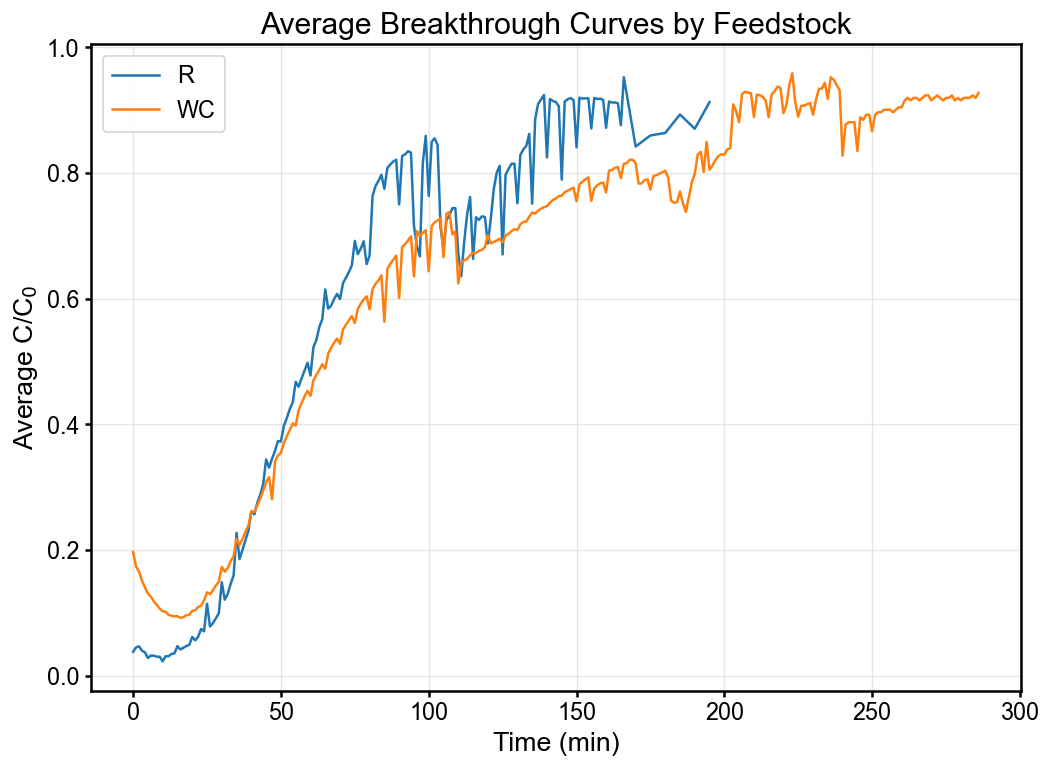

In [72]:
# ---------- Average breakthrough curves by feedstock -----------------
fig, ax = plt.subplots()
for feed, grp in df.groupby('Feed'):
    avg = grp.groupby('run time').apply(lambda d: (d['effluent mg/m^3'] / d['influent mg/m^3']).mean())
    ax.plot(avg.index, avg.values, label=feed)

ax.set_xlabel('Time (min)')
ax.set_ylabel('Average C/C$_0$')
ax.set_title('Average Breakthrough Curves by Feedstock')
ax.legend()
plt.show()

High-resolution plot saved as: breakthrough_curves_publication.png


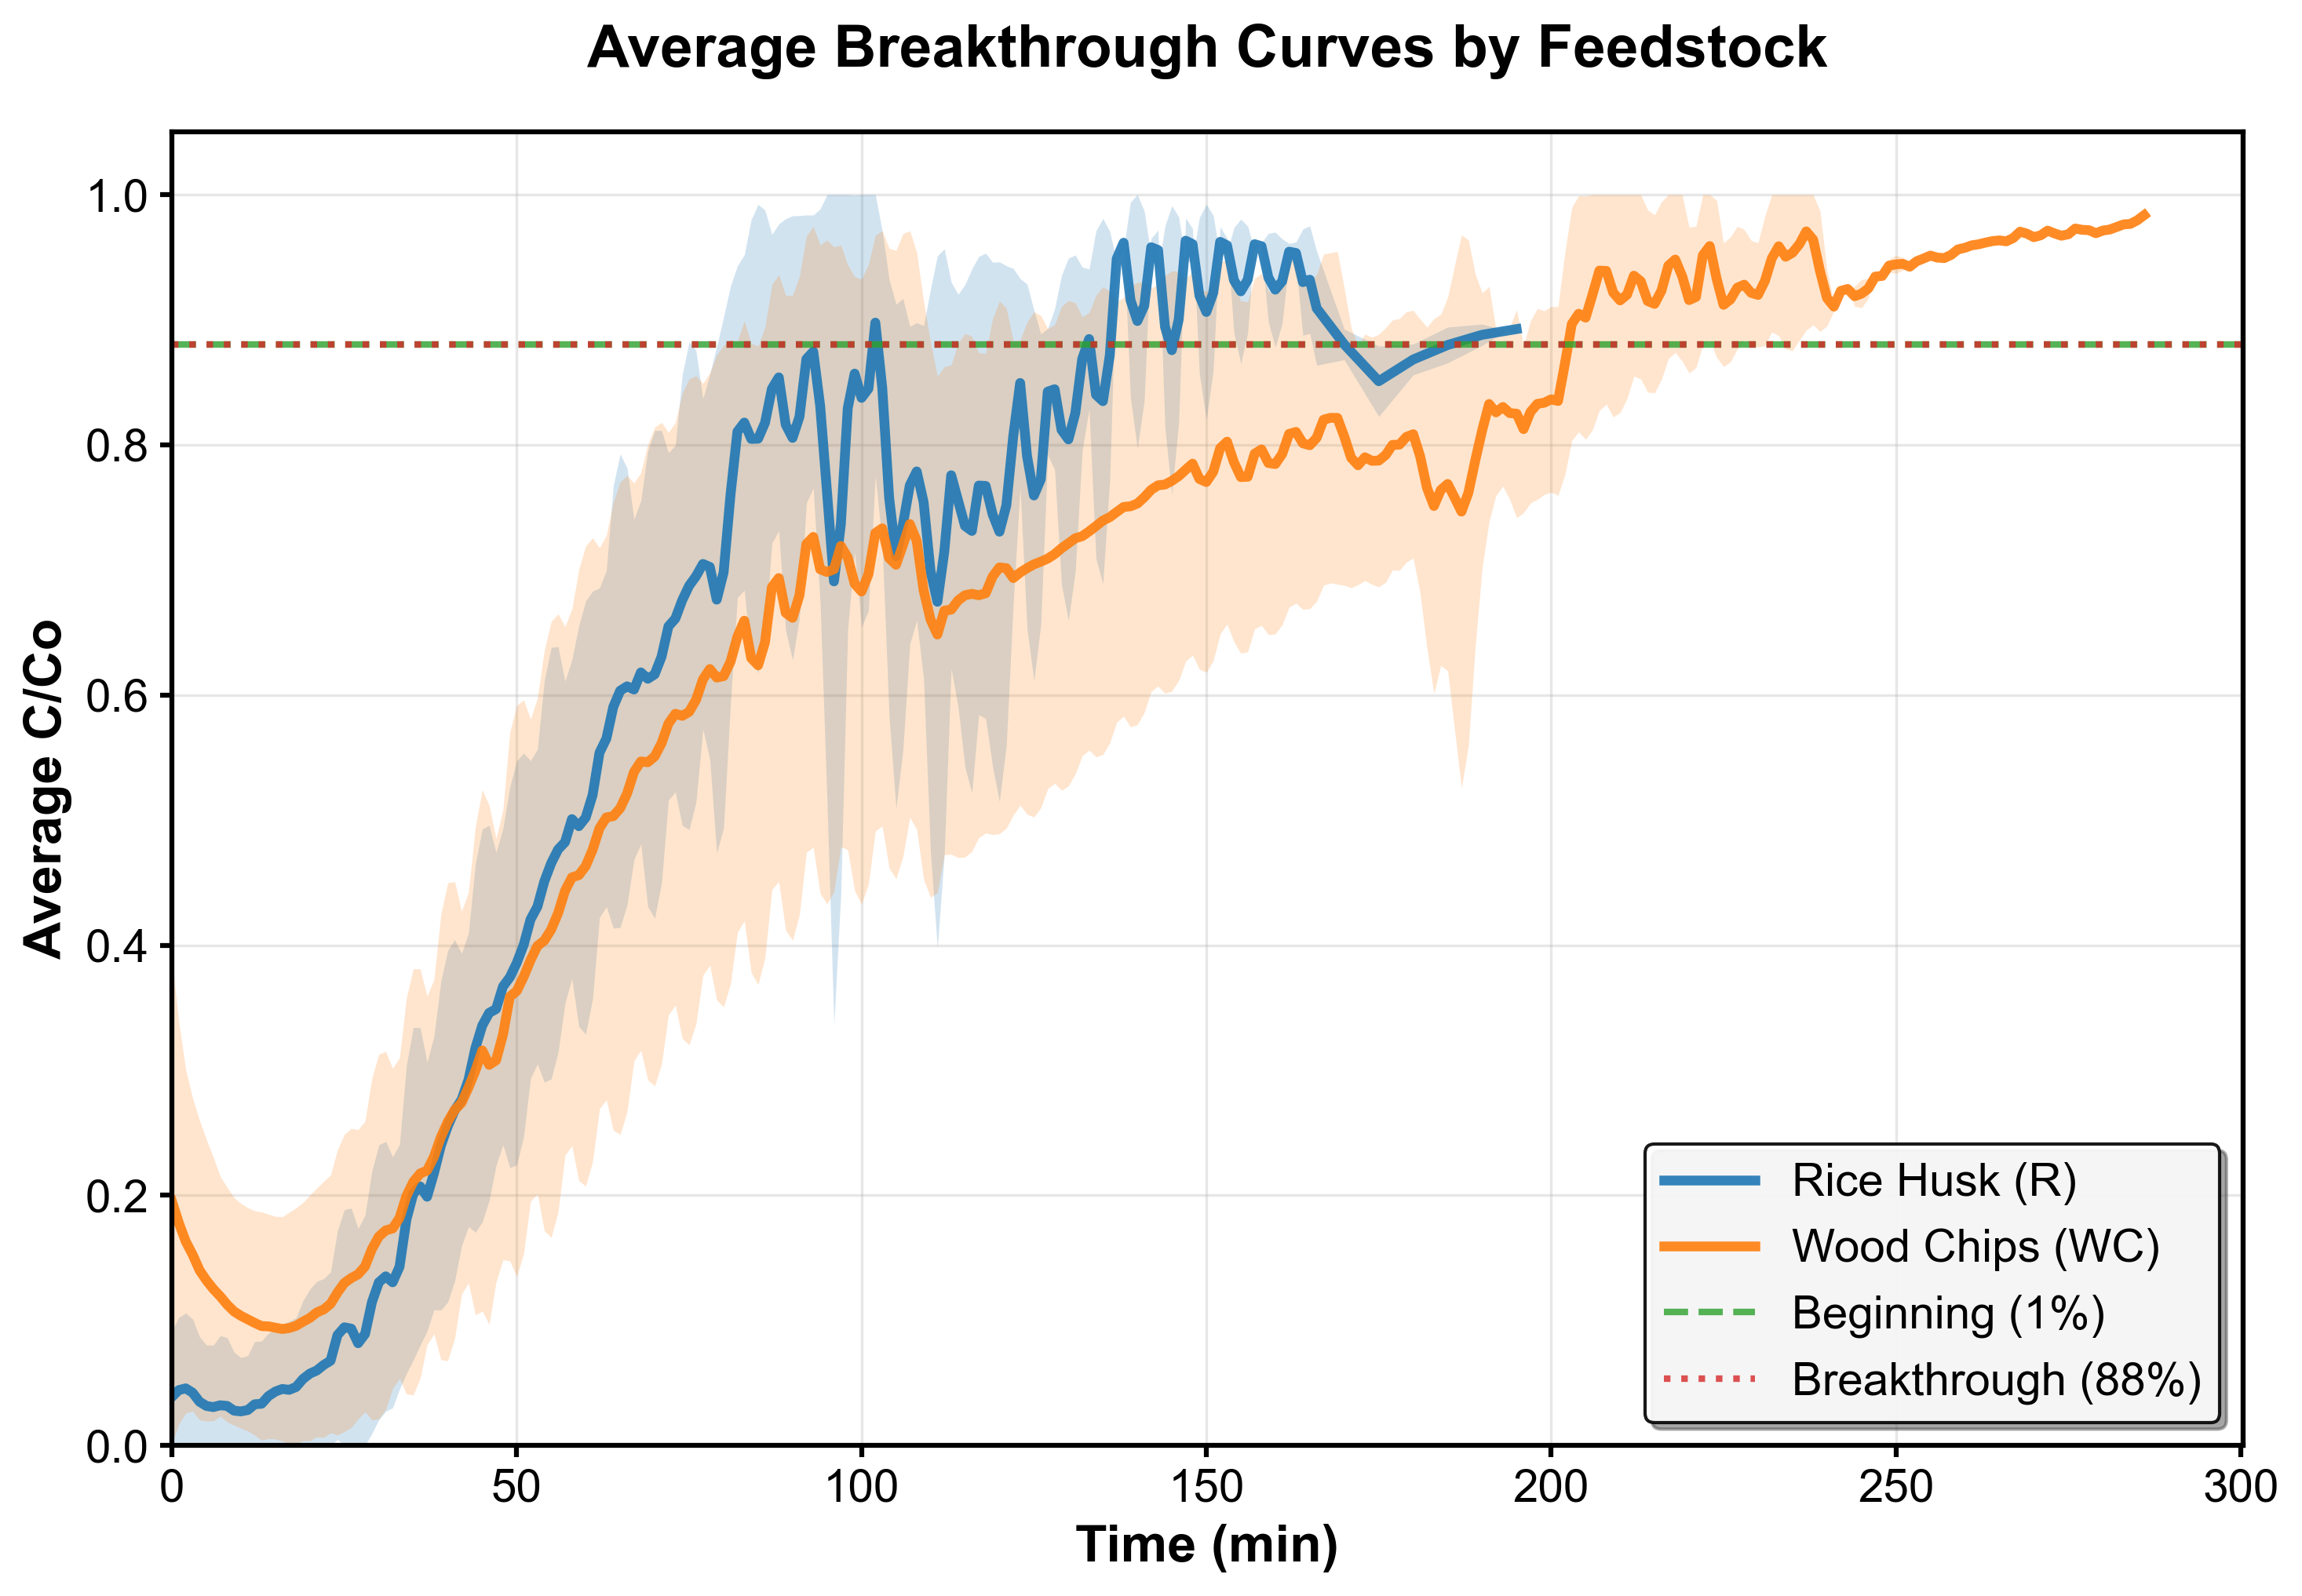

In [74]:
# --- User parameters --------------------------------------------------
DATA_FILE = 'ammoniatest4.xlsx'        # Excel file path (in same folder)
SHEET_NAME = None                      # Set to sheet name or None for first
BEGINNING_RATIO = 0.01                 # C/C0 at the beginning
BREAKTHROUGH_RATIO   = 0.88            # C/C0 at breakthrough
# ---------------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import ndimage
import seaborn as sns

# Set up publication-quality plot parameters
plt.rcParams.update({
    'figure.figsize': (10, 7),
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'font.family': 'Arial',
    'axes.linewidth': 1.5,
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'xtick.minor.width': 1,
    'ytick.minor.width': 1,
    'axes.edgecolor': 'black',
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linewidth': 0.8
})

# Define professional color palette
colors = {
    'R': '#1f77b4',      # Professional blue
    'WC': '#ff7f0e',     # Professional orange
    'breakthrough': '#d62728',  # Red for breakthrough line
    'beginning': '#2ca02c'     # Green for exhaustion line
}

# ---------- Helper functions -----------------------------------------
def logistic(t, k, t0):
    """Logistic function used for Yoon–Nelson model."""
    return 1 / (1 + np.exp(-k * (t - t0)))

def thomas_fn(t, k_th, q0_th, m, Q):
    """Thomas model in logistic form."""
    return 1 / (1 + np.exp(k_th * (q0_th * m / Q - t)))

def smooth_data(data, window_size=5, method='savgol'):
    """
    Smooth data using different methods.
    
    Parameters:
    -----------
    data : array-like
        Data to smooth
    window_size : int
        Size of smoothing window (must be odd for savgol)
    method : str
        'savgol' for Savitzky-Golay, 'gaussian' for Gaussian filter, 'rolling' for rolling mean
    """
    if len(data) < window_size:
        return data
    
    if method == 'savgol':
        from scipy.signal import savgol_filter
        # Ensure window_size is odd and not larger than data length
        window_size = min(window_size if window_size % 2 == 1 else window_size + 1, len(data))
        if window_size < 3:
            return data
        return savgol_filter(data, window_size, polyorder=2)
    
    elif method == 'gaussian':
        sigma = window_size / 3.0
        return ndimage.gaussian_filter1d(data, sigma)
    
    elif method == 'rolling':
        return pd.Series(data).rolling(window=window_size, center=True).mean().fillna(method='bfill').fillna(method='ffill').values
    
    return data

def analyse_single(run_df):
    """Compute breakthrough/exhaustion times, capacities & model fits."""
    t  = run_df['run time'].values
    C0 = run_df['influent ppm'].values
    C  = run_df['effluent ppm'].values
    Q  = run_df['Flow Rate'].iloc[0]    # L/min
    m  = run_df['mass(g)'].iloc[0]      # g
    C_ratio = C / C0

    # Beginning & Breakthrough
    idx_b = np.where(C_ratio >= BEGINNING_RATIO)[0]
    t_break = float(t[idx_b[0]]) if idx_b.size else np.nan
    idx_e = np.where(C_ratio >= BREAKTHROUGH_RATIO)[0]
    t_exh  = float(t[idx_e[0]]) if idx_e.size else np.nan

    # Capacity (trapezoidal integration up to exhaustion or full run)
    mask_int = t <= t_exh if np.isfinite(t_exh) else np.ones_like(t, bool)
    dt = np.diff(t, prepend=t[0])
    mg_removed = (C0 - C) * Q * 1e-3 * dt
    q_exp = float(mg_removed[mask_int].sum() / m)

    # Yoon–Nelson fit
    try:
        popt_yn, _ = curve_fit(logistic, t, C_ratio, p0=[0.05, np.median(t)])
        k_yn, tau_yn = popt_yn
        r2_yn = 1 - np.sum((C_ratio - logistic(t, *popt_yn))**2) / np.sum((C_ratio - C_ratio.mean())**2)
    except RuntimeError:
        k_yn = tau_yn = r2_yn = np.nan

    # Thomas fit
    try:
        popt_th, _ = curve_fit(lambda tt, k, q0: thomas_fn(tt, k, q0, m, Q),
                               t, C_ratio, p0=[0.05, 50], bounds=(0, np.inf), maxfev=10000)
        k_th, q0_th = popt_th
        r2_th = 1 - np.sum((C_ratio - thomas_fn(t, k_th, q0_th, m, Q))**2) / np.sum((C_ratio - C_ratio.mean())**2)
    except RuntimeError:
        k_th = q0_th = r2_th = np.nan

    # Average effluent after breakthrough
    if np.isfinite(t_break):
        mask = (t >= t_break) & (t <= t_exh if np.isfinite(t_exh) else True)
        avg_eff = float(C[mask].mean())
        avg_ratio = float(C_ratio[mask].mean())
    else:
        avg_eff = avg_ratio = np.nan

    return {
        't_break (min)': t_break,
        't_exhaust (min)': t_exh,
        'avg_effluent ppm': avg_eff,
        'avg_C/C0 after break': avg_ratio,
        'q_exp mg/g': q_exp,
        'k_YN (1/min)': k_yn,
        'tau_YN (min)': tau_yn,
        'R2_YN': r2_yn,
        'k_Th (1/min)': k_th,
        'q0_Th (mg/g)': q0_th,
        'R2_Th': r2_th
    }

# ---------- Load data & run analysis ---------------------------------
df = pd.read_excel(DATA_FILE, sheet_name=0)

records = []
for sample, g in df.groupby('Sample'):
    rec = analyse_single(g)
    rec.update({'Sample': sample, 'Feed': g['Feed'].iloc[0]})
    records.append(rec)

summary = pd.DataFrame(records)
summary.sort_values('t_break (min)', inplace=True)
summary.reset_index(drop=True, inplace=True)
summary_style = summary.style.format(precision=2)
summary_style

# ---------- Publication-Quality Breakthrough Curves -----------------

def plot_breakthrough_curves(df, smoothing='light', show_reference_lines=True, 
                           save_plot=True, filename='breakthrough_curves_publication.png'):
    """
    Create publication-quality breakthrough curve plots.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The main dataframe with breakthrough data
    smoothing : str
        'none', 'light', 'moderate', or 'heavy'
    show_reference_lines : bool
        Whether to show breakthrough and exhaustion reference lines
    save_plot : bool
        Whether to save the plot as high-resolution PNG
    filename : str
        Filename for saved plot
    """
    
    # Set up the figure with publication quality
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Define smoothing parameters
    smoothing_params = {
        'none': {'method': None, 'window': 1},
        'light': {'method': 'savgol', 'window': 5},
        'moderate': {'method': 'savgol', 'window': 9},
        'heavy': {'method': 'gaussian', 'window': 15}
    }
    
    # Create expanded feedstock labels
    feed_labels = {
        'R': 'Rice Husk (R)',
        'WC': 'Wood Chips (WC)'
    }
    
    # Plot each feedstock
    for feed, grp in df.groupby('Feed'):
        # Calculate average breakthrough curve
        avg_data = grp.groupby('run time').apply(
            lambda d: (d['effluent ppm'] / d['influent ppm']).mean()
        )
        
        time_data = avg_data.index.values
        ratio_data = avg_data.values
        
        # Apply smoothing if requested
        if smoothing != 'none':
            params = smoothing_params[smoothing]
            ratio_data = smooth_data(ratio_data, window_size=params['window'], 
                                   method=params['method'])
        
        # Plot the main curve
        ax.plot(time_data, ratio_data, 
                color=colors[feed], 
                linewidth=3, 
                label=feed_labels.get(feed, feed),
                alpha=0.9)
        
        # Add confidence bands if multiple samples exist
        if len(grp['Sample'].unique()) > 1:
            # Calculate standard deviation
            std_data = grp.groupby('run time').apply(
                lambda d: (d['effluent ppm'] / d['influent ppm']).std()
            ).fillna(0)
            
            if smoothing != 'none':
                std_data = smooth_data(std_data.values, window_size=params['window'], 
                                     method=params['method'])
            else:
                std_data = std_data.values
            
            # Add confidence band
            ax.fill_between(time_data, 
                          np.maximum(0, ratio_data - std_data),
                          np.minimum(1, ratio_data + std_data),
                          color=colors[feed], alpha=0.2, linewidth=0)
    
    # Add reference lines if requested
    if show_reference_lines:
        ax.axhline(y=BREAKTHROUGH_RATIO, color=colors['beginning'], 
                   linestyle='--', linewidth=2, alpha=0.8,
                   label=f'Beginning ({BEGINNING_RATIO:.0%})')
        
        ax.axhline(y=EXHAUSTION_RATIO, color=colors['breakthrough'], 
                   linestyle=':', linewidth=2, alpha=0.8,
                   label=f'Breakthrough ({BREAKTHROUGH_RATIO:.0%})')
    
    # Customize the plot
    ax.set_xlabel('Time (min)', fontweight='bold')
    ax.set_ylabel('Average C/Co', fontweight='bold')
    ax.set_title('Average Breakthrough Curves by Feedstock', fontweight='bold', pad=20)
    
    # Set axis limits and ticks
    ax.set_xlim(left=0)
    ax.set_ylim(0, 1.05)
    ax.set_yticks(np.arange(0, 1.1, 0.2))
    
    # Customize legend
    legend = ax.legend(loc='lower right', frameon=True, fancybox=True, shadow=True)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)
    legend.get_frame().set_edgecolor('black')
    
    # Improve grid
    ax.grid(True, alpha=0.3, linewidth=0.8)
    ax.set_axisbelow(True)
    
    # Tighten layout
    plt.tight_layout()
    
    # Save plot if requested
    if save_plot:
        plt.savefig(filename, dpi=300, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        print(f"High-resolution plot saved as: {filename}")
    
    plt.show()
    
    return fig, ax

# Create the publication-quality plot
fig, ax = plot_breakthrough_curves(df, smoothing='light', show_reference_lines=True)

# # ---------- Additional Plotting Options -------------------------------

# def create_multiple_plot_versions(df):
#     """Create multiple versions of the plot for different purposes."""
    
#     # Version 1: Clean version for presentations
#     print("Creating presentation version...")
#     plot_breakthrough_curves(df, smoothing='moderate', show_reference_lines=True,
#                             filename='breakthrough_curves_presentation.png')
    
#     # Version 2: Detailed version for publications
#     print("Creating publication version...")
#     plot_breakthrough_curves(df, smoothing='light', show_reference_lines=True,
#                             filename='breakthrough_curves_publication.png')
    
#     # Version 3: Raw data version for technical reports
#     print("Creating technical report version...")
#     plot_breakthrough_curves(df, smoothing='none', show_reference_lines=True,
#                             filename='breakthrough_curves_technical.png')

# # Uncomment the line below to create all versions
# # create_multiple_plot_versions(df)

# # ---------- Individual Sample Plots (Optional) -----------------------

# def plot_individual_samples(df, feed_type=None, save_plot=True):
#     """Plot individual sample curves alongside average."""
    
#     fig, ax = plt.subplots(figsize=(12, 8))
    
#     # Filter by feed type if specified
#     if feed_type:
#         df_plot = df[df['Feed'] == feed_type]
#         title_suffix = f" - {feed_labels.get(feed_type, feed_type)}"
#     else:
#         df_plot = df
#         title_suffix = ""
    
#     # Plot individual samples
#     for feed, feed_grp in df_plot.groupby('Feed'):
#         for sample, sample_grp in feed_grp.groupby('Sample'):
#             time_data = sample_grp['run time'].values
#             ratio_data = (sample_grp['effluent mg/m^3'] / sample_grp['influent mg/m^3']).values
            
#             ax.plot(time_data, ratio_data, 
#                    color=colors[feed], alpha=0.3, linewidth=1.5)
    
#     # Plot averages on top
#     for feed, grp in df_plot.groupby('Feed'):
#         avg_data = grp.groupby('run time').apply(
#             lambda d: (d['effluent mg/m^3'] / d['influent mg/m^3']).mean()
#         )
        
#         time_data = avg_data.index.values
#         ratio_data = smooth_data(avg_data.values, window_size=5, method='savgol')
        
#         ax.plot(time_data, ratio_data, 
#                color=colors[feed], linewidth=4, 
#                label=f'{feed_labels.get(feed, feed)} (Average)')
    
#     # Add reference lines
#     ax.axhline(y=BREAKTHROUGH_RATIO, color=colors['breakthrough'], 
#                linestyle='--', linewidth=2, alpha=0.8,
#                label=f'Breakthrough ({BREAKTHROUGH_RATIO:.0%})')
    
#     ax.axhline(y=EXHAUSTION_RATIO, color=colors['exhaustion'], 
#                linestyle=':', linewidth=2, alpha=0.8,
#                label=f'Exhaustion ({EXHAUSTION_RATIO:.0%})')
    
#     # Customize plot
#     ax.set_xlabel('Time (min)', fontweight='bold')
#     ax.set_ylabel('C/C₀', fontweight='bold')
#     ax.set_title(f'Individual Sample Breakthrough Curves{title_suffix}', fontweight='bold', pad=20)
#     ax.set_xlim(left=0)
#     ax.set_ylim(0, 1.05)
#     ax.legend(loc='lower right', frameon=True, fancybox=True, shadow=True)
#     ax.grid(True, alpha=0.3)
    
#     plt.tight_layout()
    
#     if save_plot:
#         filename = f'breakthrough_curves_individual{"_" + feed_type if feed_type else ""}.png'
#         plt.savefig(filename, dpi=300, bbox_inches='tight', 
#                    facecolor='white', edgecolor='none')
#         print(f"Individual samples plot saved as: {filename}")
    
#     plt.show()
#     return fig, ax

# # Uncomment to create individual sample plots
# # plot_individual_samples(df)  # All feedstocks
# # plot_individual_samples(df, feed_type='R')  # Rice husk only
# # plot_individual_samples(df, feed_type='WC')  # Wood chips only

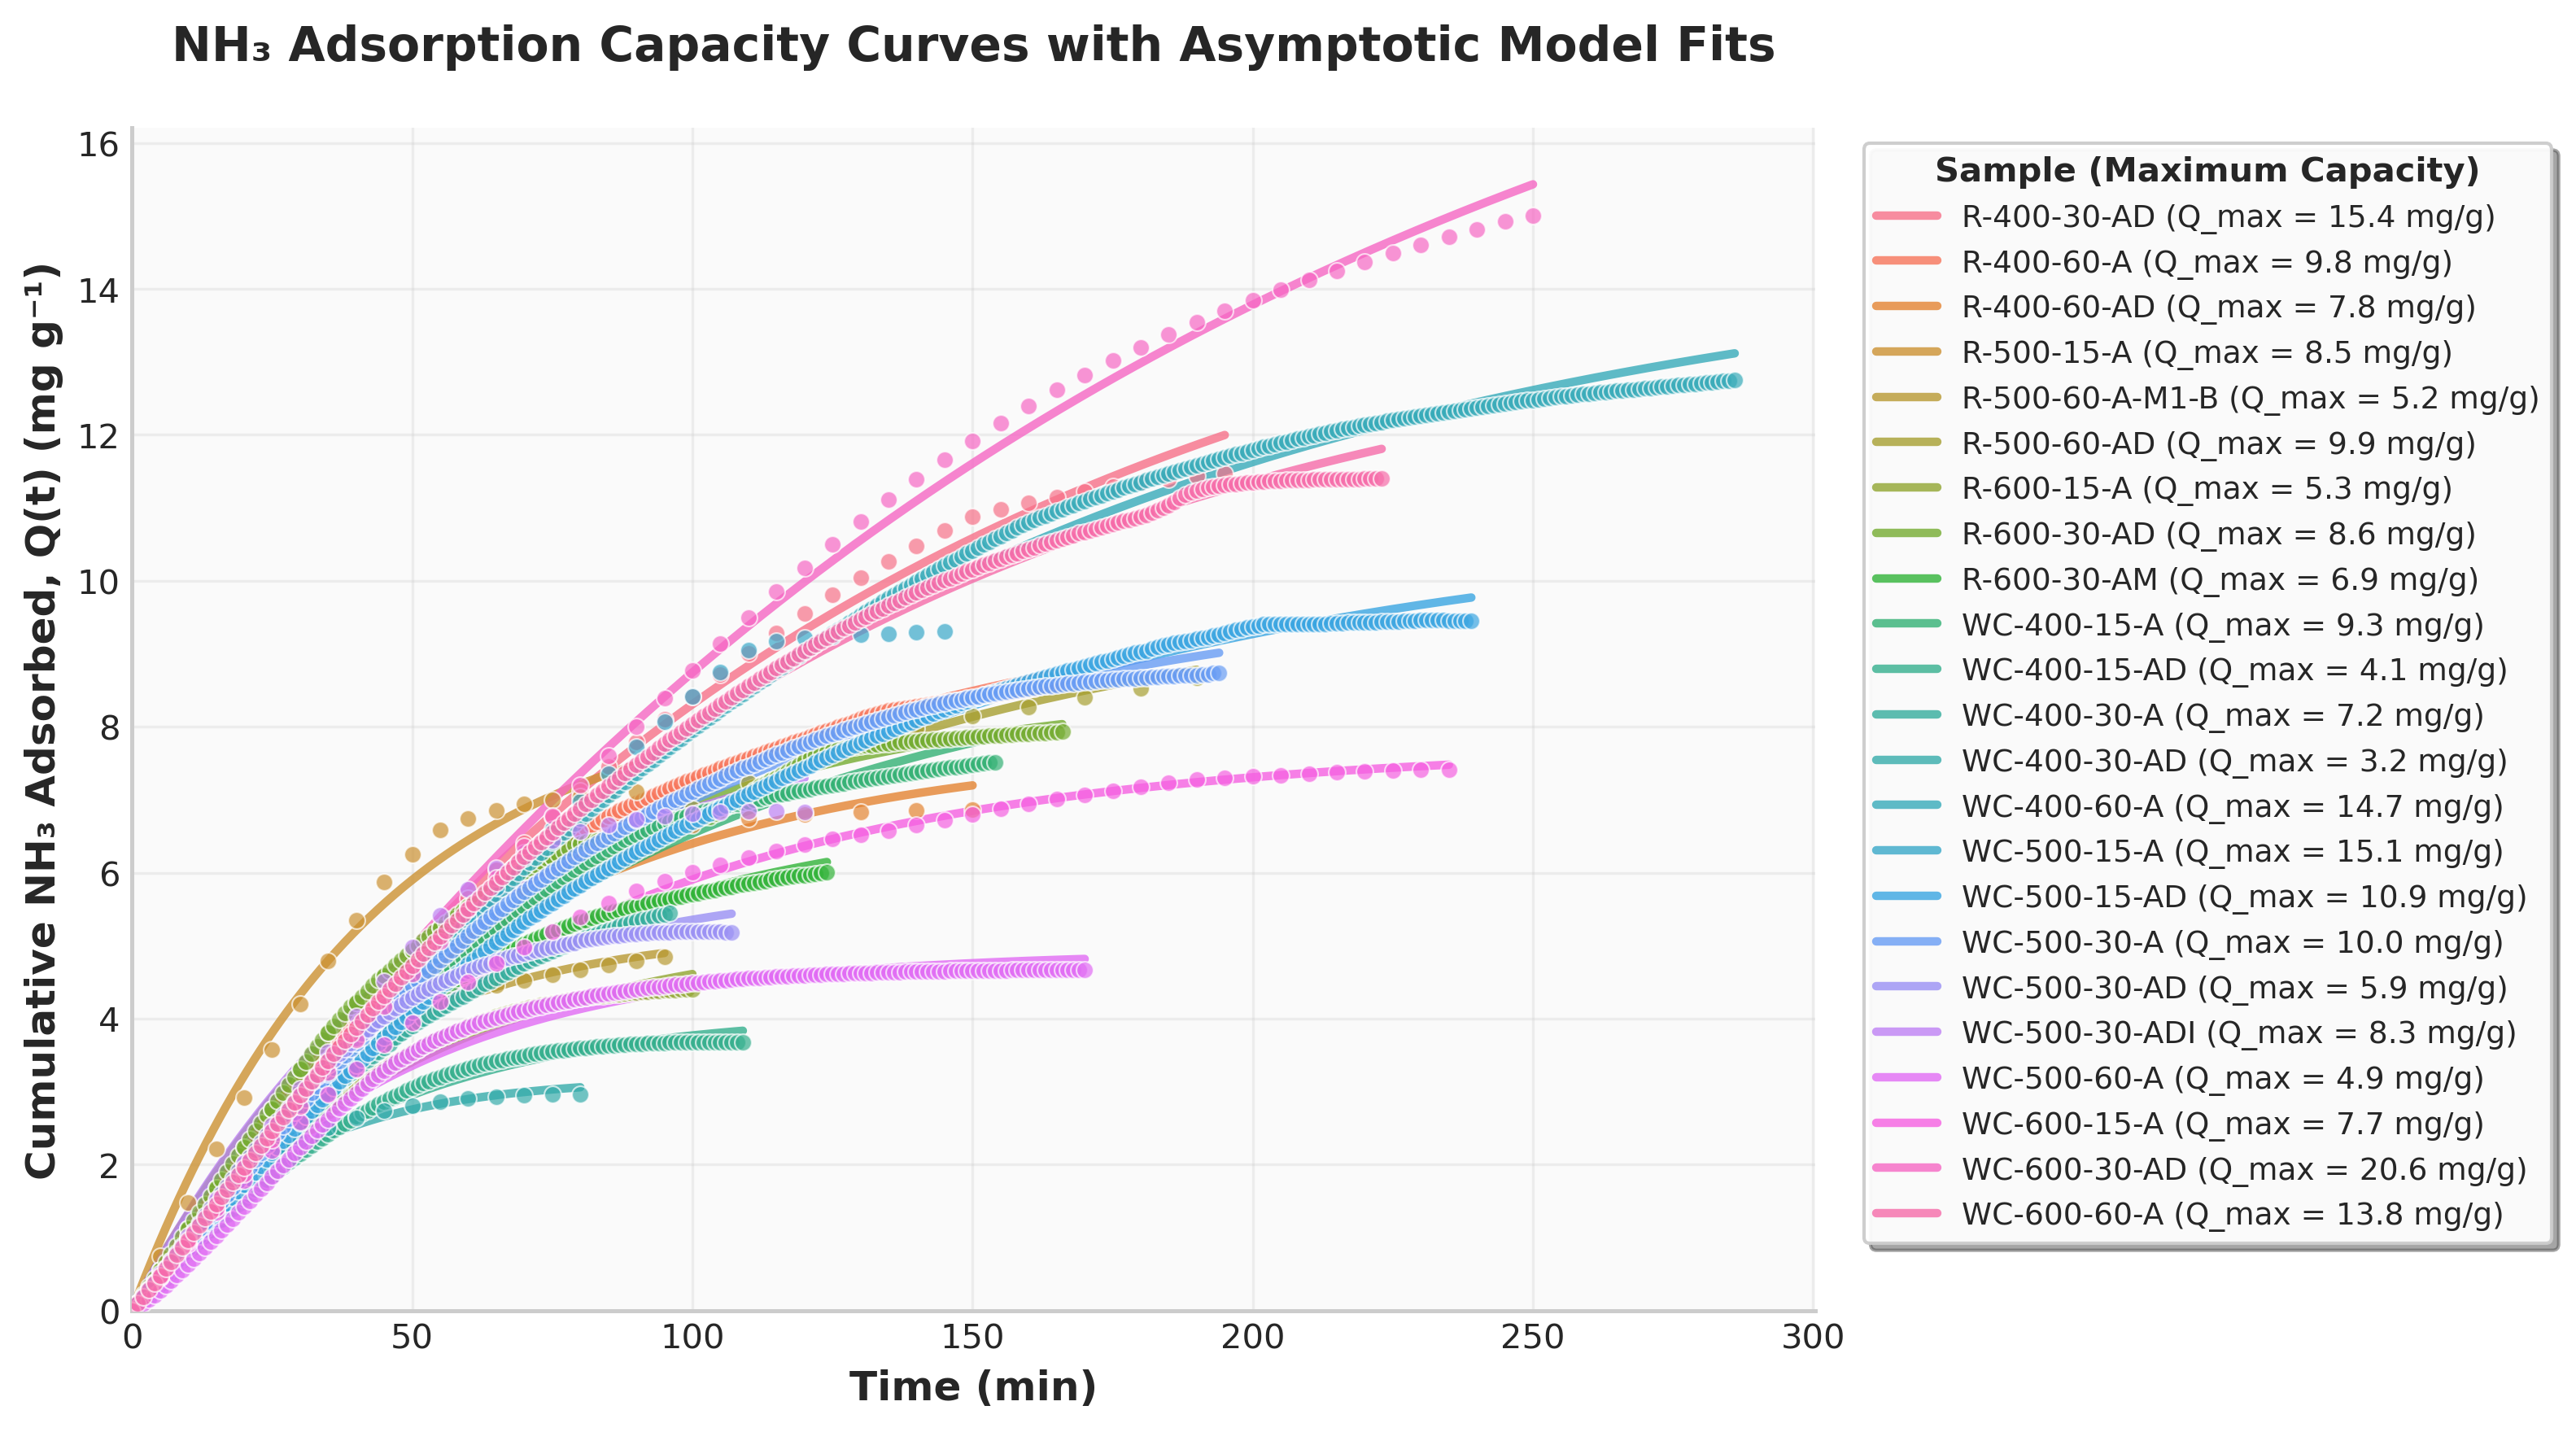


FITTED ASYMPTOTIC PARAMETERS
         Sample Qmax (mg/g) k (min⁻¹)
   WC-600-30-AD       20.63    0.0055
    R-400-30-AD       15.37    0.0078
    WC-500-15-A       15.12    0.0075
    WC-400-60-A       14.65    0.0079
    WC-600-60-A       13.85    0.0086
   WC-500-15-AD       10.87    0.0096
    WC-500-30-A        9.97    0.0121
    R-500-60-AD        9.87    0.0116
     R-400-60-A        9.84    0.0132
    WC-400-15-A        9.25    0.0123
    R-600-30-AD        8.58    0.0166
     R-500-15-A        8.46    0.0239
  WC-500-30-ADI        8.32    0.0174
    R-400-60-AD        7.78    0.0173
    WC-600-15-A        7.74    0.0144
    WC-400-30-A        7.17    0.0154
    R-600-30-AM        6.94    0.0175
   WC-500-30-AD        5.89    0.0239
     R-600-15-A        5.27    0.0208
R-500-60-A-M1-B        5.24    0.0289
    WC-500-60-A        4.92    0.0229
   WC-400-15-AD        4.08    0.0258
   WC-400-30-AD        3.19    0.0398

SUMMARY STATISTICS:
Number of samples analyzed: 23
Mean Q

In [78]:
# adsorption_capacity_analysis_optimized.py
#
# Compute cumulative NH3 adsorption capacity curves for every trial in
# `ammoniatest4.xlsx`, fit an asymptotic saturation model, and plot the results
# with publication-quality formatting.
# ------------------------ User settings ------------------------
FILE = "ammoniatest4.xlsx"     # Excel workbook in the same folder
SHEET_NAME = 0                 # 0 = first sheet, or use "Sheet1" etc.
VALID_COL  = "Valid: (Y/N)"    # Set to None if absent
# ----------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns

# Publication-quality style settings
plt.style.use('seaborn-v0_8-whitegrid')  # Clean, professional background
plt.rcParams.update({
    "figure.figsize": (10, 6),        # Larger figure for better readability
    "figure.dpi": 300,                # High resolution for publication
    "font.family": "DejaVu Sans",     # Professional font
    "font.size": 11,                  # Base font size
    "axes.titlesize": 14,             # Title font size
    "axes.labelsize": 12,             # Axis label font size
    "xtick.labelsize": 10,            # X-tick label size
    "ytick.labelsize": 10,            # Y-tick label size
    "legend.fontsize": 9,             # Legend font size
    "legend.frameon": True,           # Legend frame
    "legend.fancybox": True,          # Rounded legend corners
    "legend.shadow": True,            # Legend shadow
    "legend.framealpha": 0.9,         # Legend transparency
    "axes.spines.top": False,         # Remove top spine
    "axes.spines.right": False,       # Remove right spine
    "axes.linewidth": 1.2,            # Axis line width
    "grid.alpha": 0.3,                # Grid transparency
    "lines.linewidth": 2.0,           # Default line width
    "lines.markersize": 5,            # Default marker size
})

def asymptotic(t, Qmax, k):
    """First-order asymptotic model: Q(t) = Qmax · (1 – e⁻ᵏᵗ)."""
    return Qmax * (1 - np.exp(-k * t))

# ---------- Load & tidy data ----------
df = pd.read_excel(FILE, sheet_name=SHEET_NAME)
if VALID_COL in df.columns:
    df = df[df[VALID_COL].str.upper() == "Y"].copy()

# mg m⁻³ ➜ mg L⁻¹  (approx; 1 m³ = 1000 L)
df["Cin_mg_L"]  = df["influent mg/m^3"]  / 1000.0
df["Cout_mg_L"] = df["effluent mg/m^3"] / 1000.0

# ---------- Analyse every trial ----------
records = []
fig, ax = plt.subplots(figsize=(10, 6))

# Use a professional color palette
n_samples = len(df["Sample"].unique())
colors = sns.color_palette("husl", n_samples)  # Distinct, professional colors

sample_names = sorted(df["Sample"].unique())
for i, sample in enumerate(sample_names):
    g = df[df["Sample"] == sample].copy()
    g = g.sort_values("run time")
    
    t   = g["run time"].to_numpy()                       # min
    dt  = np.diff(np.insert(t, 0, t[0]))                 # Δt
    Cin = g["Cin_mg_L"].to_numpy()
    Cout= g["Cout_mg_L"].to_numpy()
    flow = g["Flow Rate"].iloc[0]                        # L min⁻¹
    m_bc = g["mass(g)"].iloc[0]                          # g biochar
    
    # cumulative uptake (mg g⁻¹)
    Q_t = np.cumsum((Cin - Cout) * flow * dt) / m_bc
    
    # ---- Curve-fit ----
    try:
        popt, _ = curve_fit(
            asymptotic, t, Q_t,
            p0=(Q_t[-1] if Q_t[-1] > 0 else 1.0, 0.01),
            bounds=(0, np.inf),
            maxfev=10_000,
        )
        Qmax, k = popt
    except RuntimeError:
        Qmax, k = np.nan, np.nan
    
    records.append({"Sample": sample, "Qmax (mg/g)": Qmax, "k (min⁻¹)": k})
    
    color = colors[i]
    
    # Plot data points with improved styling
    ax.scatter(t, Q_t, s=25, color=color, alpha=0.7, edgecolors='white', 
               linewidths=0.5, zorder=5)
    
    # Plot fitted curve
    if not np.isnan(Qmax):
        t_fit = np.linspace(t.min(), t.max(), 300)
        ax.plot(t_fit, asymptotic(t_fit, Qmax, k), "-", lw=2.5, color=color,
                label=f"{sample} (Q_max = {Qmax:.1f} mg/g)", alpha=0.8)

# ---------- Enhanced plot formatting ----------
ax.set_xlabel("Time (min)", fontweight='bold')
ax.set_ylabel("Cumulative NH₃ Adsorbed, Q(t) (mg g⁻¹)", fontweight='bold')
ax.set_title("NH₃ Adsorption Capacity Curves with Asymptotic Model Fits", 
             fontweight='bold', pad=20)

# Improve grid
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
ax.set_axisbelow(True)

# Enhanced legend positioning and styling
legend = ax.legend(
    bbox_to_anchor=(1.02, 1), 
    loc="upper left", 
    fontsize=9,
    title="Sample (Maximum Capacity)",
    title_fontsize=10,
    frameon=True,
    fancybox=True,
    shadow=True,
    framealpha=0.95
)
legend.get_title().set_fontweight('bold')

# Set axis limits with some padding
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

# Add subtle background color
ax.set_facecolor('#fafafa')

# Improve layout
plt.tight_layout()

# Add subplot spacing if needed
plt.subplots_adjust(right=0.75)

# Save options for publication
# plt.savefig('nh3_adsorption_curves.png', dpi=300, bbox_inches='tight', 
#             facecolor='white', edgecolor='none')
# plt.savefig('nh3_adsorption_curves.pdf', bbox_inches='tight', 
#             facecolor='white', edgecolor='none')

plt.show()

# ---------- Enhanced parameters table ----------
param_df = (pd.DataFrame(records)
            .sort_values("Qmax (mg/g)", ascending=False)
            .reset_index(drop=True))

print("\n" + "="*60)
print("FITTED ASYMPTOTIC PARAMETERS")
print("="*60)
print(param_df.to_string(index=False, formatters={
    "Qmax (mg/g)": "{:.2f}".format,
    "k (min⁻¹)":   "{:.4f}".format,
}))
print("="*60)

# Additional statistics
print(f"\nSUMMARY STATISTICS:")
print(f"Number of samples analyzed: {len(param_df)}")
print(f"Mean Qmax: {param_df['Qmax (mg/g)'].mean():.2f} ± {param_df['Qmax (mg/g)'].std():.2f} mg/g")
print(f"Mean k: {param_df['k (min⁻¹)'].mean():.4f} ± {param_df['k (min⁻¹)'].std():.4f} min⁻¹")
print(f"Range of Qmax: {param_df['Qmax (mg/g)'].min():.2f} - {param_df['Qmax (mg/g)'].max():.2f} mg/g")